# Caso de estudio - Aprendizaje supervisado

**Objetivo general:** Predecir cuáles estudiantes van a reprobar Álgebra lineal e identificar las variables más importantes para llegar a esta conclusión.


# Librerías #

In [149]:
#Integrantes: Yulianny Alvarez, Jorge Rodriguez, Juan Pablo Ramirez, Esteban Caro

In [150]:
# Importamos las librerias necesarias

## Remove Warnings
import warnings
warnings.filterwarnings("ignore")

## Data
import pandas as pd
import numpy as np

## Country Code
!pip install country_converter
!pip install pycountry_convert
import country_converter as coco
import pycountry_convert as pc

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

## Modelling
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error,  mean_absolute_error, mean_absolute_percentage_error, r2_score, classification_report
import math

# Cargar datos

Subimos el dataset a un github y luego leemos la url que almacena los datos para no tener que estar subiendo el dataset directamente desde el ordenador

In [151]:
urlcal = "https://raw.githubusercontent.com/EstebanCaroP/Proyecto-de-Aula/main/calculo_diferencial.csv"

In [152]:
#Utilizamos pandas para leer el dataset importado desde Github
dfcd = pd.read_csv(urlcal, index_col=[0])
display(dfcd.head())

,departamento,sexo,edad,direccion,t_familia,padres_status,madre_edu,padre_edu,madre_trab,padre_trab,razon,guardian,t_examen,t_estudio,faltas,soporte_edu_extra,soporte_edu_fam,monitores,actividades_extra,preuniversitario,postgrado,internet,relacion_sen,relacion_fam,tiempo_libre,salir_amigos,cons_alcohol_sem,cons_alcohol_finde,salud,ausencias,nota_01,nota_02,nota_03
0,II,M,18,U,mayor_3,S,4,4,en_casa,profesor,habilidad,madre,2,2,0,si,no,no,no,si,si,no,no,4,3,4,1,1,3,6,5,6,6
1,II,M,17,U,mayor_3,J,1,1,en_casa,otro,habilidad,padre,1,2,0,no,si,no,no,no,si,yes,no,5,3,3,1,1,3,4,5,5,6
2,II,M,15,U,menor_e3,J,1,1,en_casa,otro,otro,madre,1,2,3,si,no,si,no,si,si,yes,no,4,3,2,2,3,3,10,7,8,10
3,II,M,15,U,mayor_3,J,4,2,salud,servicios,recomendacion,madre,1,3,0,no,si,si,si,si,si,yes,yes,3,2,2,1,1,5,2,15,14,15
4,II,M,16,U,mayor_3,J,3,3,otro,otro,recomendacion,padre,1,2,0,no,si,si,no,si,si,no,no,4,3,2,1,2,5,4,6,10,10


Para  evitar que se cree una columna Unamed 0 que no nos da información, ajustamos el parámetro `index_col = [0]` al leer al dataset

# Preparación de los datos

## Análisis Exploratorio

In [153]:
from IPython.display import display, Markdown
pd.set_option('display.max_columns', None)

In [154]:
def check_df(dataframe, head=10):
    display(Markdown('**Dimensiones base general**'))
    display(dataframe.shape)

    display(Markdown('**Número de duplicados**'))
    display(dataframe.duplicated().sum())
    display(dataframe[dataframe.duplicated(keep='last')])
    display(dataframe[dataframe.duplicated(keep='first')])
    display(Markdown('**Vamos a dejar estos duplicados ante la posibilidad de que dos estudiantes tengan las mismas características**'))

    display(print(" \n "))

    display(Markdown('**Tipos**'))
    display(dataframe.dtypes)

    display(Markdown('**Primeros Registros**'))
    display(dataframe.head(head))

    display(Markdown('**Nulos**'))
    display(dataframe.isnull().sum())

    display(Markdown('**Percentiles**'))
    display(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
check_df(dfcd)

**Dimensiones base general**

(397, 33)

**Número de duplicados**

2

,departamento,sexo,edad,direccion,t_familia,padres_status,madre_edu,padre_edu,madre_trab,padre_trab,razon,guardian,t_examen,t_estudio,faltas,soporte_edu_extra,soporte_edu_fam,monitores,actividades_extra,preuniversitario,postgrado,internet,relacion_sen,relacion_fam,tiempo_libre,salir_amigos,cons_alcohol_sem,cons_alcohol_finde,salud,ausencias,nota_01,nota_02,nota_03
0,II,M,18,U,mayor_3,S,4,4,en_casa,profesor,habilidad,madre,2,2,0,si,no,no,no,si,si,no,no,4,3,4,1,1,3,6,5,6,6
383,MS,H,19,R,mayor_3,J,1,1,otro,servicios,otro,madre,2,1,1,no,no,no,no,si,si,no,no,4,3,2,1,3,5,0,6,5,0


,departamento,sexo,edad,direccion,t_familia,padres_status,madre_edu,padre_edu,madre_trab,padre_trab,razon,guardian,t_examen,t_estudio,faltas,soporte_edu_extra,soporte_edu_fam,monitores,actividades_extra,preuniversitario,postgrado,internet,relacion_sen,relacion_fam,tiempo_libre,salir_amigos,cons_alcohol_sem,cons_alcohol_finde,salud,ausencias,nota_01,nota_02,nota_03
395,II,M,18,U,mayor_3,S,4,4,en_casa,profesor,habilidad,madre,2,2,0,si,no,no,no,si,si,no,no,4,3,4,1,1,3,6,5,6,6
396,MS,H,19,R,mayor_3,J,1,1,otro,servicios,otro,madre,2,1,1,no,no,no,no,si,si,no,no,4,3,2,1,3,5,0,6,5,0


**Vamos a dejar estos duplicados ante la posibilidad de que dos estudiantes tengan las mismas características**

None

**Tipos**

departamento          object
sexo                  object
edad                   int64
direccion             object
t_familia             object
padres_status         object
madre_edu              int64
padre_edu              int64
madre_trab            object
padre_trab            object
razon                 object
guardian              object
t_examen               int64
t_estudio              int64
faltas                 int64
soporte_edu_extra     object
soporte_edu_fam       object
monitores             object
actividades_extra     object
preuniversitario      object
postgrado             object
internet              object
relacion_sen          object
relacion_fam           int64
tiempo_libre           int64
salir_amigos           int64
cons_alcohol_sem       int64
cons_alcohol_finde     int64
salud                  int64
ausencias              int64
nota_01                int64
nota_02                int64
nota_03                int64
dtype: object

**Primeros Registros**

,departamento,sexo,edad,direccion,t_familia,padres_status,madre_edu,padre_edu,madre_trab,padre_trab,razon,guardian,t_examen,t_estudio,faltas,soporte_edu_extra,soporte_edu_fam,monitores,actividades_extra,preuniversitario,postgrado,internet,relacion_sen,relacion_fam,tiempo_libre,salir_amigos,cons_alcohol_sem,cons_alcohol_finde,salud,ausencias,nota_01,nota_02,nota_03
0,II,M,18,U,mayor_3,S,4,4,en_casa,profesor,habilidad,madre,2,2,0,si,no,no,no,si,si,no,no,4,3,4,1,1,3,6,5,6,6
1,II,M,17,U,mayor_3,J,1,1,en_casa,otro,habilidad,padre,1,2,0,no,si,no,no,no,si,yes,no,5,3,3,1,1,3,4,5,5,6
2,II,M,15,U,menor_e3,J,1,1,en_casa,otro,otro,madre,1,2,3,si,no,si,no,si,si,yes,no,4,3,2,2,3,3,10,7,8,10
3,II,M,15,U,mayor_3,J,4,2,salud,servicios,recomendacion,madre,1,3,0,no,si,si,si,si,si,yes,yes,3,2,2,1,1,5,2,15,14,15
4,II,M,16,U,mayor_3,J,3,3,otro,otro,recomendacion,padre,1,2,0,no,si,si,no,si,si,no,no,4,3,2,1,2,5,4,6,10,10
5,II,H,16,U,menor_e3,J,4,3,servicios,otro,reputacion,madre,1,2,0,no,si,si,si,si,si,yes,no,5,4,2,1,2,5,10,15,15,15
6,II,H,16,U,menor_e3,J,2,2,otro,otro,recomendacion,madre,1,2,0,no,no,no,no,si,si,yes,no,4,4,4,1,1,3,0,12,12,11
7,II,M,17,U,mayor_3,S,4,4,otro,profesor,recomendacion,madre,2,2,0,si,si,no,no,si,si,no,no,4,1,4,1,1,1,6,6,5,6
8,II,H,15,U,menor_e3,S,3,2,servicios,otro,recomendacion,madre,1,2,0,no,si,si,no,si,si,yes,no,4,2,2,1,1,1,0,16,18,19
9,II,H,15,U,mayor_3,J,3,4,otro,otro,recomendacion,madre,1,2,0,no,si,si,si,si,si,yes,no,5,5,1,1,1,5,0,14,15,15


**Nulos**

departamento          0
sexo                  0
edad                  0
direccion             0
t_familia             0
padres_status         0
madre_edu             0
padre_edu             0
madre_trab            0
padre_trab            0
razon                 0
guardian              0
t_examen              0
t_estudio             0
faltas                0
soporte_edu_extra     0
soporte_edu_fam       0
monitores             0
actividades_extra     0
preuniversitario      0
postgrado             0
internet              0
relacion_sen          0
relacion_fam          0
tiempo_libre          0
salir_amigos          0
cons_alcohol_sem      0
cons_alcohol_finde    0
salud                 0
ausencias             0
nota_01               0
nota_02               0
nota_03               0
dtype: int64

**Percentiles**

,count,mean,std,min,0%,5%,50%,95%,99%,100%,max
edad,397.0,16.705290,1.279716,15.0,15.0,15.0,17.0,19.0,20.00,22.0,22.0
madre_edu,397.0,2.748111,1.097301,0.0,0.0,1.0,3.0,4.0,4.00,4.0,4.0
padre_edu,397.0,2.521411,1.090672,0.0,0.0,1.0,2.0,4.0,4.00,4.0,4.0
t_examen,397.0,1.450882,0.696840,1.0,1.0,1.0,1.0,3.0,4.00,4.0,4.0
t_estudio,397.0,2.032746,0.838731,1.0,1.0,1.0,2.0,4.0,4.00,4.0,4.0
faltas,397.0,0.335013,0.742714,0.0,0.0,0.0,0.0,2.0,3.00,3.0,3.0
relacion_fam,397.0,3.944584,0.894400,1.0,1.0,2.0,4.0,5.0,5.00,5.0,5.0
tiempo_libre,397.0,3.234257,0.996476,1.0,1.0,2.0,3.0,5.0,5.00,5.0,5.0
salir_amigos,397.0,3.108312,1.112762,1.0,1.0,1.0,3.0,5.0,5.00,5.0,5.0
cons_alcohol_sem,397.0,1.478589,0.889143,1.0,1.0,1.0,1.0,3.0,5.00,5.0,5.0


El dataset tiene 397 registros y 33 columnas. También se observa que tenemos dos datos duplicados, los cuales dejaremos incluidos dada la probabilidad de que existan estudiantes que tengan las mismas características. No se tienen nulos en el dataset.

Podemos observar algunas variables numéricas importantes como la edad, con un promedio de 16.7 años para los estudiantes, un promedio del estudiantado de 0.33 faltas lo cual es un buen indicio de la asistencia a la universidad y por último notamos que las notas de los tres parciales gira alrededor de 10 y 11.

In [155]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        'Ratio': 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print('##########################################')
    if plot:
        plt.figure(figsize=(12,6))
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

cat_cols = [col for col in dfcd.columns if dfcd[col].dtypes == "O"]
for col in cat_cols:
    cat_summary(dfcd, col, plot=False)

    departamento      Ratio
II           350  88.161209
MS            47  11.838791
##########################################
   sexo      Ratio
M   209  52.644836
H   188  47.355164
##########################################
   direccion      Ratio
U        308  77.581864
R         89  22.418136
##########################################
          t_familia      Ratio
mayor_3         283  71.284635
menor_e3        114  28.715365
##########################################
   padres_status      Ratio
J            355  89.420655
S             42  10.579345
##########################################
           madre_trab      Ratio
otro              142  35.768262
servicios         103  25.944584
en_casa            60  15.113350
profesor           58  14.609572
salud              34   8.564232
##########################################
           padre_trab      Ratio
otro              217  54.659950
servicios         112  28.211587
profesor           30   7.556675
en_casa            20 

En el bloque de código mostrado anteriormente se tiene un resumen de las variables categóricas del dataset. Algunos datos importantes se observan, tales como:

La mayoría de los estudiantes de la muestra están matriculados en el programa de Ingeniería Industrial (cerca del 88%)
Cerca del 53% de los estudiantes son mujeres
El 78% aproximadamente de los estudiantes viven en áreas urbanas y el 22% en áreas rurales.

## Análisis univariado

### Variables Categoricas

In [156]:
print('Variables de los datos: \n')
print(dfcd.columns.values)

Variables de los datos: 

['departamento' 'sexo' 'edad' 'direccion' 't_familia' 'padres_status'
 'madre_edu' 'padre_edu' 'madre_trab' 'padre_trab' 'razon' 'guardian'
 't_examen' 't_estudio' 'faltas' 'soporte_edu_extra' 'soporte_edu_fam'
 'monitores' 'actividades_extra' 'preuniversitario' 'postgrado' 'internet'
 'relacion_sen' 'relacion_fam' 'tiempo_libre' 'salir_amigos'
 'cons_alcohol_sem' 'cons_alcohol_finde' 'salud' 'ausencias' 'nota_01'
 'nota_02' 'nota_03']


In [157]:
#Función para encontrar porcentaje de los datos

def proporcion(DataFrame, NameColums, description):
  print('-'*len(description))
  print(description, '\n')

  inte_count = dict(DataFrame[NameColums].value_counts())

  for i in inte_count:
    x = round(inte_count[i]/len(DataFrame[NameColums])*100, 2)
    print("{}: {}%".format(i,x))

  print('-'*len(description))

**Nivel de educación de la madre**

In [158]:
basemadre = dfcd.groupby(['madre_edu'])[['sexo']].count().reset_index().sort_values('madre_edu', ascending = True).rename(columns ={'sexo':'count'})
basemadre['madre_edu'] = basemadre['madre_edu'].astype('string')

# crear gráfica
fig = px.bar(basemadre, x='madre_edu', y='count', title ='<b>Nivel de educación de la madre<b>')

# agregar detalles a la gráfica
fig.update_layout(
    xaxis_title = 'educación de la madre',
    yaxis_title = 'Cantidad',
    template = 'simple_white',
    title_x = 0.5)

fig.show()

Podemos notar en el gráfico de barras que hay una gran diferencia entre las madres que tienen un nivel 0 de educación y los demás niveles, debemos tener en cuenta este desbalance para los próximos análisis.

**Nivel de educación padre**

In [159]:
basepadre = dfcd.groupby(['padre_edu'])[['sexo']].count().reset_index().sort_values('sexo', ascending = False).rename(columns ={'sexo':'count'})
basepadre['padre_edu'] = basepadre['padre_edu'].astype('string')

# crear gráfica
fig = px.pie(basepadre, names='padre_edu', values='count', title ='<b>Nivel de educación del padre<b>')

# agregar detalles a la gráfica
fig.update_layout(
    xaxis_title = 'Educación del padre',
    yaxis_title = 'Cantidad',
    template = 'simple_white',
    title_x = 0.5)

fig.show()

Así como en los niveles de educación de la madre, podemos notar que en los niveles de educacion del padre existe un gran desbalance entre el nivel 0 y los demás niveles.

Ya que se evidencia una alta correlación entre las variables madre_edu y padre_edu, debido a que sus gráficos de líneas son bastante similares, (lo evidenciaremos un poco mas adelante en el analisis bivariado con la variable objetivo) y sus niveles van de 0 a 4, se realiza una transformación donde se busca el promedio entre ambas, esta nueva variable la llamaremos padres_edu.

In [160]:
dfcd['padres_edu'] = (dfcd['madre_edu'] + dfcd['padre_edu']) / 2
dfcd

,departamento,sexo,edad,direccion,t_familia,padres_status,madre_edu,padre_edu,madre_trab,padre_trab,razon,guardian,t_examen,t_estudio,faltas,soporte_edu_extra,soporte_edu_fam,monitores,actividades_extra,preuniversitario,postgrado,internet,relacion_sen,relacion_fam,tiempo_libre,salir_amigos,cons_alcohol_sem,cons_alcohol_finde,salud,ausencias,nota_01,nota_02,nota_03,padres_edu
0,II,M,18,U,mayor_3,S,4,4,en_casa,profesor,habilidad,madre,2,2,0,si,no,no,no,si,si,no,no,4,3,4,1,1,3,6,5,6,6,4.0
1,II,M,17,U,mayor_3,J,1,1,en_casa,otro,habilidad,padre,1,2,0,no,si,no,no,no,si,yes,no,5,3,3,1,1,3,4,5,5,6,1.0
2,II,M,15,U,menor_e3,J,1,1,en_casa,otro,otro,madre,1,2,3,si,no,si,no,si,si,yes,no,4,3,2,2,3,3,10,7,8,10,1.0
3,II,M,15,U,mayor_3,J,4,2,salud,servicios,recomendacion,madre,1,3,0,no,si,si,si,si,si,yes,yes,3,2,2,1,1,5,2,15,14,15,3.0
4,II,M,16,U,mayor_3,J,3,3,otro,otro,recomendacion,padre,1,2,0,no,si,si,no,si,si,no,no,4,3,2,1,2,5,4,6,10,10,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,MS,H,21,R,mayor_3,J,1,1,otro,otro,habilidad,otro,1,1,3,no,no,no,no,no,si,no,no,5,5,3,3,3,3,3,10,8,7,1.0
393,MS,H,18,R,menor_e3,J,3,2,servicios,otro,habilidad,madre,3,1,0,no,no,no,no,no,si,yes,no,4,4,1,3,4,5,0,11,12,10,2.5
394,MS,H,19,U,menor_e3,J,1,1,otro,en_casa,habilidad,padre,1,1,0,no,no,no,no,si,si,yes,no,3,2,3,3,3,5,5,8,9,9,1.0
395,II,M,18,U,mayor_3,S,4,4,en_casa,profesor,habilidad,madre,2,2,0,si,no,no,no,si,si,no,no,4,3,4,1,1,3,6,5,6,6,4.0


In [161]:
basepadres = dfcd.groupby(['padres_edu'])[['sexo']].count().reset_index().rename(columns ={'sexo':'count'})
basepadres['padres_edu'] = basepadres['padres_edu'].astype('string')

# crear gráfica
fig = px.pie(basepadres, names='padres_edu', values='count', title ='<b>Nivel de educación promedio de los padres<b>')

# agregar detalles a la gráfica
fig.update_layout(
    xaxis_title = 'Promedio educación padres',
    yaxis_title = 'Cantidad',
    template = 'simple_white',
    title_x = 0.5)

fig.show()

Con respecto a la variable de forma independiente, acá vemos un mayor balance entre la educacion promedio de los padres, a excepción de los niveles 0 que no tiene ningun registro y 0,5 que solo tiene 2 registros.

**Carrera que cursa el estudiante**

In [162]:
basedepartamento = dfcd.groupby(['departamento'])[['sexo']].count().reset_index().rename(columns ={'sexo':'count'})
basedepartamento['departamento'] = basedepartamento['departamento'].astype('string')

# crear gráfica
fig = px.bar(basedepartamento, x='departamento', y='count', title ='<b>Carrera que cursa el estudiante<b>')

# agregar detalles a la gráfica
fig.update_layout(
    xaxis_title = 'Carrera',
    yaxis_title = 'Cantidad',
    template = 'simple_white',
    title_x = 0.5)

fig.show()

Aquí podemos notar que las variables no están muy bien balanceadas y que en la carrera de ingeniería industrial hay mas de 300 estudiantes más inscritos en nuestra base de datos, debemos tener en cuenta que los estudiantes de ingeniería de sistemas (MS), solo representan alrededor de un 12% de la muestra.

**Genero estudiantes**

In [163]:
basesexo = dfcd.groupby(['sexo'])['departamento'].count().reset_index().sort_values('departamento', ascending = False).rename(columns ={'departamento':'count'})
basesexo['sexo'] = basesexo['sexo'].astype('string')

cant_ed = dfcd['sexo'].count()

# hacer la gráfica
fig = px.pie(basesexo , values = 'count', names = 'sexo', title = '<b>Genero estudiantes <b>',
             hole = .5)

# poner detalles a la gráfica
fig.update_layout(
    template = 'simple_white',
    legend_title = '<b>% Genero<b>',
    title_x = 0.5,
    annotations = [dict(text = 'Muestras:<br>'+str(cant_ed), x=0.5, y = 0.5, font_size = 20, showarrow = False)])

fig.show()

Con respecto al género notamos un mejor balance entre sus valores, ahora más adelante analizaremos la correlación con respecto a la variable independiente para ver si es pertinente trabajar con esta variable.

**Dirección de vivienda del estudiante**

In [164]:
basedireccion = dfcd.groupby(['direccion'])[['sexo']].count().reset_index().sort_values('sexo', ascending = False).rename(columns ={'sexo':'count'})
basedireccion['direccion'] = basedireccion['direccion'].astype('string')

# crear gráfica
fig = px.bar(basedireccion, x='direccion', y='count', title ='<b>dirección del estudiante<b>')

# agregar detalles a la gráfica
fig.update_layout(
    xaxis_title = 'dirección',
    yaxis_title = 'Cantidad',
    template = 'simple_white',
    title_x = 0.5)

fig.show()

En este grafico se evidencia una gran diferencia entre ambos valores en la variable de la dirección del estudiante, hay 250 estudiantes más viviendo en zonas urbanas con respecto a los estudiantes de las zonas rurales, aun así debemos tener en cuenta que los estudiantes de áreas rurales (R), representan alrededor del 22% de la muestra.

**Tamaño familia estudiante** **texto en negrita**

In [165]:
basefamilia = dfcd.groupby(['t_familia'])[['sexo']].count().reset_index().rename(columns ={'sexo':'count'})

cant_ed = dfcd['t_familia'].count()

# hacer la gráfica
fig = px.pie(basefamilia , values = 'count', names = 't_familia', title = '<b>Tamaño familia estudiante<b>',
             hole = .5)

# poner detalles a la gráfica
fig.update_layout(
    template = 'simple_white',
    legend_title = '<b>% tamaño familia<b>',
    title_x = 0.5,
    annotations = [dict(text = 'Muestras:<br>'+str(cant_ed), x=0.5, y = 0.5, font_size = 20, showarrow = False)])

fig.show()

En el anterior grafico podemos notar la cantidad de datos en cada una de las variables, aun no esté totalmente balanceado, las familias con menos de 3 integrantes representan cerca del 29%, por lo que es un porcentaje considerable a estudiar.

**status padres del estudiante**

In [166]:
basestpadres = dfcd.groupby(['padres_status'])[['sexo']].count().reset_index().sort_values('sexo', ascending = False).rename(columns ={'sexo':'count'})
basestpadres['padres_status'] = basestpadres['padres_status'].astype('string')

# crear gráfica
fig = px.bar(basestpadres, x='padres_status', y='count', title ='<b>status padres del estudiante<b>')

# agregar detalles a la gráfica
fig.update_layout(
    xaxis_title = 'status padres',
    yaxis_title = 'Cantidad',
    template = 'simple_white',
    title_x = 0.5)

fig.show()

Del grafico anterior podemos ver claramente el desbalance de la muestra ya que la cantidad de padres separados (S), solo representa un 10%.

**Trabajo del padre y de la madre**

In [167]:
display(proporcion(dfcd, 'madre_trab', 'Trabajos de las madres'))
display(proporcion(dfcd, 'padre_trab', 'Trabajos de las padres'))

----------------------
Trabajos de las madres 

otro: 35.77%
servicios: 25.94%
en_casa: 15.11%
profesor: 14.61%
salud: 8.56%
----------------------


None

----------------------
Trabajos de las padres 

otro: 54.66%
servicios: 28.21%
profesor: 7.56%
en_casa: 5.04%
salud: 4.53%
----------------------


None

In [168]:
import plotly.express as px
import pandas as pd

# Supongamos que tienes un DataFrame llamado 'dfcd' con las columnas 'madre_trab' y 'padre_trab'

# Contar la cantidad de cada valor en madre_trab y padre_trab
madre_counts = dfcd["madre_trab"].value_counts()
padre_counts = dfcd["padre_trab"].value_counts()

# Unir los conteos en un solo DataFrame
total_counts = pd.concat([madre_counts, padre_counts], axis=1, keys=["madre_trab", "padre_trab"])

# Crear un DataFrame adecuado para Plotly Express
total_counts.reset_index(inplace=True)
total_counts = total_counts.rename(columns={"index": "Trabajos"})

# Crear gráfico de barras agrupadas con Plotly Express
fig = px.bar(total_counts, x="Trabajos", y=["madre_trab", "padre_trab"],
             title="Cantidad de padres y madres con sus trabajos",
             labels={"value": "Cantidad", "variable": "Parentesco"},
             color_discrete_sequence=["#FF5733", "#00AABB"],
             barmode="group",  # Esto agrupa las barras de madres y padres
             height=500)

fig.update_layout(xaxis_title="Trabajos", yaxis_title="Cantidad")
fig.update_xaxes(tickangle=45)
fig.update_layout(legend_title="Parentesco")
fig.show()



La mayor cantidad de trabajos ocupados por los padres y madres de los estudiantes se encuentran en la categoria 'otros'. Existe mayor cantidad de madres ocupando labores de casa que los padres en este mismo oficio, sin embargo los padres representan mayor cantidad de cargos de servicio civil. Las profesiones menos ocupadas son el área de docuente y salud.

**Razón para elegir carrera**

In [169]:
proporcion(dfcd, 'razon', 'Razones para elegir la carrera')

------------------------------
Razones para elegir la carrera 

habilidad: 36.78%
recomendacion: 27.46%
reputacion: 26.45%
otro: 9.32%
------------------------------


In [170]:
import plotly.express as px
import pandas as pd

# Contar la cantidad de cada valor en 'razon'
razon_counts = dfcd['razon'].value_counts().reset_index()
razon_counts.columns = ['Razon', 'Count']

# Crear el gráfico de barras con Plotly Express
fig = px.bar(razon_counts, x='Razon', y='Count',
             title='Razones para elegir la carrera',
             labels={'Count': 'Cantidad', 'Razon': 'Razón'},
             color_discrete_sequence=['#00AABB'],
             height=500)

# Ajustar el título
fig.update_layout(title_x=0.5)

# Mostrar el gráfico
fig.show()


El 36,78% de los estudiantes eligieron la carrera por creer tcener mayor habilidad, cerca del 54% de los estudiantes están ya sea por recomendación o reputación de la carrera y el 9,22% están por otro motivo

**Tutor del estudiante**

In [171]:
proporcion(dfcd, 'guardian', 'Tutor del estudiante')

--------------------
Tutor del estudiante 

madre: 69.27%
padre: 22.67%
otro: 8.06%
--------------------


In [172]:

# Calcular los conteos de los tutores
guardian_counts = dfcd['guardian'].value_counts().reset_index()
guardian_counts.columns = ['Tutor', 'Count']

# Crear el gráfico de pastel con Plotly Express
fig = px.pie(guardian_counts, names='Tutor', values='Count',
             title='Representación de tutores de los estudiantes',
             color_discrete_sequence=px.colors.qualitative.Pastel,
             height=500)

# Mostrar el gráfico
fig.show()


De los 397 estudiantes el 69% tiene como tutor a la madre, el 23% al padre y solo el 8% alguien diferente a la madre y al padre.

**Apoyo educativo adicional**

In [173]:
proporcion(dfcd, 'soporte_edu_extra', 'Apoyo educativo adicional')

-------------------------
Apoyo educativo adicional 

no: 86.9%
si: 13.1%
-------------------------


In [174]:
import plotly.express as px
import pandas as pd

# Supongamos que tienes un DataFrame llamado 'dfcd' con la columna 'soporte_edu_extra'

# Calcular los conteos para cada categoría en 'soporte_edu_extra'
support_counts = dfcd['soporte_edu_extra'].value_counts().reset_index()
support_counts.columns = ['Apoyo Educativo Extra', 'Count']

# Crear el gráfico de barras con Plotly Express
fig = px.bar(support_counts, x='Apoyo Educativo Extra', y='Count',
             title='Apoyo educativo adicional',
             labels={'Count': 'Cantidad', 'Apoyo Educativo Extra': 'Tipo de Apoyo'},
             color_discrete_sequence=px.colors.qualitative.Plotly,
             height=500)

# Ajustar el título
fig.update_layout(title_x=0.5)

# Mostrar el gráfico
fig.show()


Cerca del 87% de los estudiantes no cuentan con apoyo economico adicional. Esta variable será analizada con más enfasis en las relaciones bivariadas, dado que presenta un gran desbalance lo que podría afectar al modelo de en las predicciones.



**Apoyo educativo familiar**

In [175]:
# crear dataset
base = dfcd.groupby(['soporte_edu_fam'])[['nota_03']].count().reset_index().sort_values('nota_03', ascending = False).rename(columns ={'nota_03':'count'})
# crear gráfica
fig = px.pie(base, names='soporte_edu_fam', values='count', title ='<b>Apoyo educativo familiar<b>')

# agregar detalles a la gráfica
fig.update_layout(
    xaxis_title = 'Apoyo educativo familiar',
    yaxis_title = 'Cantidad',
    template = 'simple_white',
    title_x = 0.5)

fig.show()

Se observa que un poco mas de la mitad de los estudiantes cuentan con un apoyo educativo familiar y que esta es una variable con categorias considerablemenete balanceadas

**Monitores**

In [176]:
#crear dataset
base = dfcd.groupby(['monitores'])[['nota_03']].count().reset_index().sort_values('nota_03', ascending = False).rename(columns ={'nota_03':'count'})
# crear gráfica
fig = px.bar(base, x='monitores', y='count', title ='<b>Tutores privados (monitores)<b>')

# agregar detalles a la gráfica
fig.update_layout(
    xaxis_title = 'Tiene tutores privados',
    yaxis_title = 'Cantidad',
    template = 'simple_white',
    title_x = 0.5)

fig.show()

Para la variable monitores vemos que esta bastante balanceada, podriamos considerar incluirla en el modelo, vemos que la mayoria de estudiantes no tienen clases con tutores extra

**Actividades extra-escolares**

In [177]:
# crear dataset
base = dfcd.groupby(['actividades_extra'])[['nota_03']].count().reset_index().sort_values('nota_03', ascending = False).rename(columns ={'nota_03':'count'})

# crear gráfica
fig = px.pie(base, names='actividades_extra', values='count', title ='<b>Actividades extra-escolares<b>')

# agregar detalles a la gráfica
fig.update_layout(
    template = 'simple_white',
    title_x = 0.5)

fig.show()

Para la variable actividades extra-escolares vemos que sus categorias estan bastante balanceadas, con una ligera diferencia son mas los estudiantes que si realizan actividades extra-escolares

**Pre-universitario**

In [178]:
# crear dataset
base = dfcd.groupby(['preuniversitario'])[['nota_03']].count().reset_index().sort_values('nota_03', ascending = False).rename(columns ={'nota_03':'count'})

# crear gráfica
fig = px.bar(base, x='preuniversitario', y='count', title ='<b> Pre-universitario <b>')

# agregar detalles a la gráfica
fig.update_layout(
    xaxis_title = 'Realizo pre-universitario',
    yaxis_title = 'Cantidad',
    template = 'simple_white',
    title_x = 0.5)

fig.show()

La mayoria de los estudiantes realizaron un curso pre-universitario sin embargo una parte relevante no lo realizo, vemos una variable poco desbalanceada, es importante ver su comportamiento vs la variable respuesta

**Post-grado**

In [179]:
# crear dataset
base = dfcd.groupby(['postgrado'])[['nota_03']].count().reset_index().sort_values('nota_03', ascending = False).rename(columns ={'nota_03':'count'})

# crear gráfica
fig = px.pie(base, names='postgrado', values='count', title ='<b>Deseo de realizar un post-grado<b>')

# agregar detalles a la gráfica
fig.update_layout(
    template = 'simple_white',
    title_x = 0.5)

fig.show()

Para esta variable vemos que un 95% de los datos se concentra en los estudiantes que si desean realizar un post-grado, al estar tan desbalanceada podriamos considerar eliminarla del modelo

**Internet**

In [180]:
# crear dataset
base = dfcd.groupby(['internet'])[['nota_03']].count().reset_index().sort_values('nota_03', ascending = False).rename(columns ={'nota_03':'count'})
base['internet'] = base['internet'].replace('yes', 'si')
# crear gráfica
fig = px.bar(base, x='internet', y='count', title ='<b> Acceso a internet en casa <b>')

# agregar detalles a la gráfica
fig.update_layout(
    xaxis_title = 'Acceso a internet',
    yaxis_title = 'Cantidad',
    template = 'simple_white',
    title_x = 0.5)

fig.show()

La mayoria de estudiantes tiene acceso a internet en sus hogares, se tiende a ver un poco desbalanceada la variable por ello veremos su comportamiento en el bivariado para tomar una decisión

**Relación romántica**

In [181]:
# crear dataset
base = dfcd.groupby(['relacion_sen'])[['edad']].count().reset_index().sort_values('edad', ascending = False).rename(columns ={'edad':'count'})
base['relacion_sen'] = base['relacion_sen'].replace('yes', 'si')
# crear gráfica
fig = px.pie(base, names='relacion_sen', values='count', title ='<b>Relación romántica<b>')

# agregar detalles a la gráfica
fig.update_layout(
    template = 'simple_white',
    title_x = 0.5)

fig.show()

La mayor parte de los estudiantes no se encuentran en una relación romántica, es una variable que parece estar un poco balanceada

### Variables numéricas

**edad de los estudiantes**

In [182]:
fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Histogram(x=dfcd['edad'], name='Histograma edad', marker_color='pink'),
    row=1, col=1
)

fig.add_trace(
    go.Box(y=dfcd['edad'], name='Boxplot de la edad', marker_color='coral'),
    row=1, col=2
)

fig.update_layout(
    title_text="Distribución de la edad de los estudiantes",
    template='simple_white')
fig.show()

En el histograma que podemos ver a la izquierda, podemos notar que la muestra se comporta de forma más o menos normal, con una cola hacia la derecha, y apoyándonos en el boxplot, podemos ver que el 50% de los datos (entre los q1 y q3), están entre 16 y 18 con una media de 17, con unos bigotes no muy alargados y 2 datos atípico, ya que solo 1 estudiante tiene 22 años y otro 21.

**Tiempo en que demoró en realizar el primer examen**

In [183]:
proporcion(dfcd,'t_examen', 'Tiempo de primer examen')

-----------------------
Tiempo de primer examen 

1: 64.74%
2: 27.46%
3: 5.79%
4: 2.02%
-----------------------


In [184]:
fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Histogram(x = dfcd['t_examen'], name='Histograma tiempo del primer examen', marker_color='LightSkyBlue'),
    row=1, col=1
)

fig.add_trace(
    go.Box(y = dfcd['t_examen'], name='Boxplot tiempo del primer examen', marker_color='LightSkyBlue'),
    row=1, col=2
)

fig.update_layout(
    title_text="Distribución tiempo del primer examen",
    template='simple_white')
fig.show()

Alrededor de 366 estudiantes (el 92.2% del total) realizaron el primer examen de cálculo diferencia en menos de 30 minutos. Tan solo 8 estudiantes se toman más de una hora para realizar el examen. Esto puede ser un indicio del rendimiento en las notas alcanzadas en el primer examen. En el boxplot la media, el minimo y el primer cuantil tienen el mismo valor esto se debe a que más del cincuenta porciento de los daatos se encuentran en una sola categoría (1), es decir que menos del 50% de los estudiantes solo les toma 15 minutos realizar el examen.

**Tiempo de estudio semanal**

In [185]:
proporcion(dfcd,'t_estudio', 'Tiempo de estudio semanal')

-------------------------
Tiempo de estudio semanal 

2: 50.13%
1: 26.7%
3: 16.37%
4: 6.8%
-------------------------


In [186]:
fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Histogram(x = dfcd['t_estudio'], name='Histograma tiempo de estudio semanal', marker_color='MediumPurple'),
    row=1, col=1
)

fig.add_trace(
    go.Box(y = dfcd['t_estudio'], name='Boxplot tiempo de estudio semanal', marker_color='MediumPurple'),
    row=1, col=2
)

fig.update_layout(
    title_text="Distribución tiempo de estudio de cálculo semanal",
    template='simple_white')
fig.show()

A pesar la poca proporción de estudiantes que duran más de 1 hora haciendo el primer examen de cálculo, la mitad de los estudiantes le dedican de 2 a 5 horas de estudio a la semana. En el box plot, la media y el cuantil 3 toman el mismo valor, esto nos dice que tan solo el 25% de los estudiantes estudian 5 horas o más a la semana. El bigote inferior del boxplot está traslapado con el cuantil 1 dado el 26.7% de los datos corresponen al valor mínimo que es uno.

**Número de faltas a la clase**

In [187]:
proporcion(dfcd, 'faltas', 'Número de faltas a clase')

------------------------
Número de faltas a clase 

0: 78.84%
1: 12.85%
2: 4.28%
3: 4.03%
------------------------


In [188]:
fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Histogram(x = dfcd['faltas'], name='Histograma faltas a clases', marker_color='lightseagreen'),
    row=1, col=1
)


fig.update_layout(
    title_text="Distribución faltas a clase de álgebra",
    template='simple_white')
fig.show()

Cerca del 79% de los estudiantes no presentan ausencia en las clases de cálculo diferencial. El 21% falta ya sea 1, 2 o 3 veces a clases. **Esta variable se tendrá en cuenta al momento de entrenar el modelo**. Dado el desbalance que existe entre las cantidades de faltas a clases.

**Calidad de las relaciones familiares**

In [189]:
# crear dataset
base = dfcd.groupby(['relacion_fam'])[['nota_03']].count().reset_index().sort_values('nota_03', ascending = False).rename(columns ={'nota_03':'count'})
#Asignamos etiquetas más faciles de comprender para la variable
base['relacion_fam']=base['relacion_fam'].replace(1,'Muy mala')
base['relacion_fam']=base['relacion_fam'].replace(2,'Regular')
base['relacion_fam']=base['relacion_fam'].replace(3,'Buena')
base['relacion_fam']=base['relacion_fam'].replace(4,'Muy buena')
base['relacion_fam']=base['relacion_fam'].replace(5,'Excelente')
# crear gráfica
fig = px.bar(base, x='relacion_fam', y='count', title ='<b> Calidad de las relaciones familiares <b>')

# agregar detalles a la gráfica
fig.update_layout(
    xaxis_title = 'Calidad',
    yaxis_title = 'Cantidad',
    template = 'simple_white',
    title_x = 0.5)

fig.show()

Vemos una buena distribucion de los datos y podremos más adelante ver si realmente ayudan a explicar la variable respuesta

**Tiempo libre después de la universidad**

In [190]:
# crear dataset
base = dfcd.groupby(['tiempo_libre'])[['nota_03']].count().reset_index().sort_values('nota_03', ascending = False).rename(columns ={'nota_03':'count'})
#Asignamos etiquetas más faciles de comprender para la variable
base['tiempo_libre']=base['tiempo_libre'].replace(1,'Muy bajo')
base['tiempo_libre']=base['tiempo_libre'].replace(2,'Bajo')
base['tiempo_libre']=base['tiempo_libre'].replace(3,'Medio')
base['tiempo_libre']=base['tiempo_libre'].replace(4,'Alto')
base['tiempo_libre']=base['tiempo_libre'].replace(5,'Muy alto')
# crear gráfica
fig = px.bar(base, x='tiempo_libre', y='count', title ='<b> Tiempo libre después de la universidad <b>')

# agregar detalles a la gráfica
fig.update_layout(
    xaxis_title = 'Tiempo',
    yaxis_title = 'Cantidad',
    template = 'simple_white',
    title_x = 0.5)

fig.show()

Vemos nuevamente una buena distribución y esta vez con valores mas significativos para las ultimas categorias

**Salir con amigos**

In [191]:
base = dfcd.groupby(['salir_amigos'])[['departamento']].count().reset_index().sort_values('departamento', ascending = False).rename(columns ={'departamento':'count'})

# crear gráfica
fig = px.bar(base, x='salir_amigos', y='count', barmode ='group', title ='<b> Nivel de salidas con amigos<b>')

# agregar detalles a la gráfica
fig.update_layout(
    xaxis_title = 'Cantidad',
    yaxis_title = 'Puesto de trabajo',
    template = 'simple_white',
    title_x = 0.5)

fig.show()

Observamos que la gran mayoría de los estudiantes tienden a ser moderados en cuanto a las salidas con sus amigos, considerando moderado las escalas 1,2 y 3. Concentrándose la gran mayoría de ellos en el nivel 3.

**Consumo de alcohol entre semana**

In [192]:
base = dfcd.groupby(['cons_alcohol_sem'])[['departamento']].count().reset_index().sort_values('departamento', ascending=False).rename(columns={'departamento': 'conteo'})

fig = px.bar(base, x='cons_alcohol_sem', y='conteo', barmode='group', title='<b>Consumo de alcohol entre semana<b>')

fig.update_layout(
    xaxis_title='Cantidad',
    yaxis_title='Nivel de consumo de alcohol en jornada laboral',
    template='simple_white',
    title_x=0.5
)

fig.show()


**Consumo de alcohol fines de semana**

In [193]:
base = dfcd.groupby(['cons_alcohol_finde'])[['departamento']].count().reset_index().sort_values('departamento', ascending=False).rename(columns={'departamento': 'conteo'})

fig = px.bar(base, x='cons_alcohol_finde', y='conteo', barmode='group', title='<b>Consumo de alcohol fines de semana<b>')

fig.update_layout(
    xaxis_title='Cantidad',
    yaxis_title='Nivel de consumo de alcohol durante el fin de semana',
    template='simple_white',
    title_x=0.5
)

fig.show()


En relación a los hábitos de consumo de alcohol por parte del estudiantado, notamos que en su gran mayoría consumen poco alcohol tanto en semana como fines semana.

**Salud**

In [194]:
base = dfcd.groupby(['salud'])[['departamento']].count().reset_index().sort_values('departamento',ascending=False).rename(columns={'departamento':'conteo'})
fig = px.pie(base, names='salud', values='conteo', title ='<b>Estado de salud de los estudiantes <b>')
fig.update_layout(
    xaxis_title = 'Estado de salud',
    yaxis_title = 'Cantidad',
    template = 'simple_white',
    title_x = 0.5)

fig.show()

Se observa que el estado de salud de los estudiantes es en su gran mayoría aceptable, considerando aceptable como los niveles 3,4 y 5.

**Ausencias**

In [195]:
base = dfcd.groupby(['ausencias'])[['departamento']].count().reset_index().sort_values('departamento',ascending=False).rename(columns={'departamento':'conteo'})
fig = px.bar(base, x='ausencias', y='conteo', barmode ='group', title ='<b>Número de ausencias<b>')
fig.update_layout(
    xaxis_title = 'Cantidad',
    yaxis_title = 'Número de ausencias',
    template = 'simple_white',
    title_x = 0.5)

In [196]:
dfcd['ausencias'].mean()

5.69521410579345

Para esta variable, se observa que el número de ausencias a la universidad es bajo en su gran mayoría, dado que quienes han tenido cero ausencias son mucho más que quienes han tenido más de 1.

**Nota 1**

In [197]:
base = dfcd['nota_01']
fig = px.histogram(base,marginal='box')

fig.update_xaxes(title_text='Nota obtenida')

fig.show()

No tenemos datos atípicos para esta variable bajo el criterio del rango intercuartílico. El 50% de los estudiantes obtienen una nota de entre 8 y 13 para el primer parcial.

**Nota 2**

In [198]:
base = dfcd['nota_02']
fig = px.histogram(base,marginal='box')

fig.update_xaxes(title_text='Nota obtenida')
fig.update_traces(marker_color='green')

fig.show()

Observamos que hay un aumento de estudiantes que obtienen cero para el segundo parcial, y el rango intercuartílico se desplaza un poco a la derecha, aunque la gran masa de datos a la izquiera de la mediana indica que sigue habiendo un alto número de estudiantes que pierden el examen dos.

**Nota 3 - Variable objetivo**

In [199]:
base = dfcd['nota_03']
fig = px.histogram(base,marginal='box')

fig.update_xaxes(title_text='Nota obtenida')
fig.update_traces(marker_color='blue')

fig.show()

Finalmente, el 50% de los estudiantes de la muestra obtienen una nota de entre 8 y 14 para el tercer parcial. Además hay un aumento considerable en el número de estudiantes que pierden el tercer examen en cero.

Bajo el criterio del rango intercuartílico, no tenemos datos atípicos para la variable objetivo.

## Análisis bivariado

### Variables categóricas

**Nivel de educacion de la madre vs nota_03**

In [200]:
import plotly.express as px
import pandas as pd

fig = px.box(dfcd, x='madre_edu', y='nota_03',
             title='Comparación entre Nivel de Educación de la Madre y Nota 03',
             labels={'madre_edu': 'Nivel de Educación de la Madre', 'nota_03': 'Nota 03'},
             template='plotly',
             height=400)

# Mostrar el gráfico
fig.show()


Podemos notar en el anterior grafico de forma general cuando la educacion de la madre aumenta, las notas del estudiante en promedio también lo hacen, aunque en el nivel cero de educación de la madre se puede notar que hay un promedio más alto, se debe tener en cuenta que en este nivel solo se tienen 3 datos, por lo que se puede tomar como atípicos.

**Nivel de educacion del padre vs nota_03**

In [201]:
# crear base
fig = px.box(dfcd, x='padre_edu', y='nota_03',
             title='Comparación entre Nivel de Educación del padre y Nota 03',
             labels={'padre_edu': 'Nivel de Educación del padre', 'nota_03': 'Nota 03'},
             template='plotly',
             height=400)

# Mostrar el gráfico
fig.show()


In [202]:
# crear dataset
basebipadre = dfcd.groupby(['padre_edu'])[['nota_03']].median().reset_index().sort_values('nota_03', ascending = True)

# crear gráfica
fig = px.bar(basebipadre, x='padre_edu', y='nota_03', barmode ='group', title ='<b>Nota promedio del estudiante segun nivel educacion del padre<b>')

# agregar detalles a la gráfica
fig.update_layout(
    xaxis_title = 'nivel de educacion padre',
    yaxis_title = 'notas',
    template = 'simple_white',
    title_x = 0.5)

fig.show()

Podemos notar en el anterior grafico boxplot que de forma general cuando la educacion del padre aumenta, las notas del estudiante en promedio también lo hacen, aunque en el nivel cero de educación del padre se puede notar que hay un promedio más alto, se debe tener en cuenta que en este nivel solo se tienen 2 datos, por lo que se puede tomar como atípicos. Debido a que esta variable y la educacion de la madre se comportan de manera muy similar por ello se decide realizar la nueva variable mencionada anteriormente: padres_edu y asi esperamos que el modelo pueda mejorar su desempeño.

**nivel promedio de educación de los padres vs nota_03**

In [203]:
fig = px.box(dfcd,
             x='padres_edu',
             y='nota_03',
             color='padres_edu')

fig.update_layout(
    title_text='Distribucion de las notas de los estudiantes segun la educacion promedio de sus padres',
    xaxis=dict(
        title='educacion promedio padres',
        titlefont_size=16
    ),
    yaxis=dict(
        title='Nota estudiantes',
        titlefont_size=16
    ),
    template='simple_white'
)
fig.show()

Como podemos notar  el boxplot tiene un comportamiento muy parecido a las variables madre_edu y padre_edu, a medida que la educacion promedio de los padres aumenta, el promedio de la nota de los estudiantes también lo hace, a excepción de los datos atipicos que en este caso se alojan en 0.5 y contiene 2 registros.

**departamento que cursa el estudiante vs nota_03**

In [204]:
fig = make_subplots(rows=1, cols=2)

nota_by_type = dfcd.groupby('departamento')['nota_03'].mean()
nota_by_II = dfcd.loc[dfcd['departamento']=='II']
nota_by_MS = dfcd.loc[dfcd['departamento']=='MS']

colors=['orangered', 'green']

fig.add_trace(
    go.Bar(
        x=['Ingenieria industrial', 'Ingenieria de sistemas'],
        y=nota_by_type.values,
        name='Bar Chart',
        text=np.round(nota_by_type.values),
        marker_color=colors),
    row=1, col=1
)

fig.add_trace(
    go.Box(y=nota_by_II['nota_03'], name='Ingenieria industrial'),
    row=1, col=2
)

fig.add_trace(
    go.Box(y=nota_by_MS['nota_03'], name='Ingenieria de sistemas'),
    row=1, col=2
)

fig.update_layout(
    title_text="nota promedio segun carrera del estudiante",
    template='simple_white')
fig.show()

Como podemos notar en este análisis bivario, los estudiantes de ingeniería industrial en promedio sacan una nota de aproximadamente 10, al igual que los estudiantes de ingeniería de sistemas, es decir en promedio ambos pierden y teniendo en cuenta que esta variable esta considerablemente desbalanceada, consideramos que esta variable no tiene mayor peso para nuestro análisis y decidimos sacarla de nuestro modelo.

**Genero del estudiante vs nota**

In [205]:
fig = make_subplots(rows=1, cols=2)

nota_by_type = dfcd.groupby('sexo')['nota_03'].mean()
nota_by_H = dfcd.loc[dfcd['sexo']=='H']
nota_by_M = dfcd.loc[dfcd['sexo']=='M']

colors=['purple', 'orange']

fig.add_trace(
    go.Bar(
        x=['Hombres', 'Mujeres'],
        y=nota_by_type.values,
        name='Bar Chart',
        text=np.round(nota_by_type.values),
        marker_color=colors),
    row=1, col=1
)

fig.add_trace(
    go.Box(y=nota_by_H['nota_03'], name='Hombres'),
    row=1, col=2
)

fig.add_trace(
    go.Box(y=nota_by_M['nota_03'], name='Mujeres'),
    row=1, col=2
)

fig.update_layout(
    title_text="nota promedio segun genero del estudiante",
    template='simple_white')
fig.show()

Como podemos ver en los gráficos anteriores, la nota promedio de los hombres es de 11, mientras que la de las mujeres es de 10, aun no es un cambio muy gran debemos tener en cuenta que el rango Inter cuartil de las notas de los hombres esta entre 9 y 14, mientras que el de las mujeres esta entre 8 y 13, por lo que consideramos que la variable podría tener un peso importante en el modelo.

**Nota del estudiante vs direccion**

In [206]:
fig = make_subplots(rows=1, cols=2)

nota_by_type = dfcd.groupby('direccion')['nota_03'].mean()
nota_by_R = dfcd.loc[dfcd['direccion']=='R']
nota_by_U = dfcd.loc[dfcd['direccion']=='U']

colors=['red', 'blue']

fig.add_trace(
    go.Bar(
        x=['Rural', 'Urbana'],
        y=nota_by_type.values,
        name='Bar Chart',
        text=np.round(nota_by_type.values),
        marker_color=colors),
    row=1, col=1
)

fig.add_trace(
    go.Box(y=nota_by_R['nota_03'], name='Rural'),
    row=1, col=2
)

fig.add_trace(
    go.Box(y=nota_by_U['nota_03'], name='Urbana'),
    row=1, col=2
)

fig.update_layout(
    title_text="nota promedio segun direccion del estudiante",
    template='simple_white')
fig.show()

Teniendo en cuenta que, en las gráficas anteriores, los estudiantes de zona rural en promedio pierden con una nota de 9 y los estudiantes de zona urbana en promedio pierden con una nota de 11, pero teniendo en cuenta que el 50% de los datos en el caso de rural esta entre 7 y 9, y en el caso de urbana están entre 9 y 14, se decide dejar la variable para el modelo de predicción.

**Tamaño de la familia vs nota_03 estudiante**

In [207]:
# crear dataset
basebitfamilia = dfcd.groupby(['t_familia'])[['nota_03']].mean().reset_index()

# crear gráfica
fig = px.bar(basebitfamilia, x='t_familia', y='nota_03', barmode ='group', title ='<b>Nota final de los estudiantes segun tamaño de su familia<b>')

# agregar detalles a la gráfica
fig.update_layout(
    xaxis_title = 'Tamaño familia',
    yaxis_title = 'nota promedio segun tamaño familia',
    template = 'simple_white',
    title_x = 0.5)

fig.show()

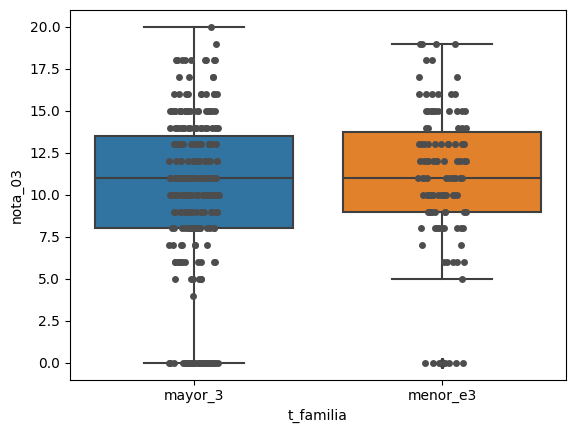

In [208]:
#Generamos los boxplot
ax = sns.boxplot(
    data = dfcd,
    y = 'nota_03',
    x = 't_familia'
)

#Generamos los puntos

ax = sns.stripplot(
    data = dfcd,
    y = 'nota_03',
    x = 't_familia',
    color = '.3'
)

Debido a que no se ve una gran variación entre la nota promedio de las familias mayores a 3 y las menores a 3, se decide que esta variable no se tendrá en cuenta en el modelo final.

**nota_03 vs status_padres**

In [209]:
fig = make_subplots(rows=1, cols=2)

nota_by_type = dfcd.groupby('padres_status')['nota_03'].mean()
nota_by_J = dfcd.loc[dfcd['padres_status']=='J']
nota_by_S = dfcd.loc[dfcd['padres_status']=='S']

colors=['green', 'orange']

fig.add_trace(
    go.Bar(
        x=['Juntos', 'Separados'],
        y=nota_by_type.values,
        name='Bar Chart',
        text=np.round(nota_by_type.values),
        marker_color=colors),
    row=1, col=1
)

fig.add_trace(
    go.Box(y=nota_by_J['nota_03'], name='Juntos'),
    row=1, col=2
)

fig.add_trace(
    go.Box(y=nota_by_S['nota_03'], name='Separados'),
    row=1, col=2
)

fig.update_layout(
    title_text="nota promedio segun status de los padres del estudiante",
    template='simple_white')
fig.show()

Debido a que no se ve una gran variación entre el estatus de los padres ya que la media es 10 en los padres juntos y 11 en los separados y teniendo en cuenta que los rangos inter-cuartiles en los boxplot no representa un mayor cambio, y además teniendo en cuenta que la variable esta desbalanceada en gran medida, se concluye que esta variable no tendrá un peso considerable en el modelo.

**Trabajo de la madre vs Nota 3**

In [210]:
fig = make_subplots(rows=1, cols=2)

nota_by_type = dfcd.groupby('madre_trab')['nota_03'].mean()
nota_by_en_casa = dfcd.loc[dfcd['madre_trab']=='en_casa']
nota_by_salud = dfcd.loc[dfcd['madre_trab']=='salud']
nota_by_otro = dfcd.loc[dfcd['madre_trab']=='otro']
nota_by_servicios = dfcd.loc[dfcd['madre_trab']=='servicios']
nota_by_profesor = dfcd.loc[dfcd['madre_trab']=='profesor']

colors = ['orangered', 'green', 'purple', 'orange','turquoise']

fig.add_trace(
    go.Bar(
        x = ['En casa', 'Salud', 'Otro', 'Servicios', 'Profesor'],
        y = nota_by_type.values,
        name = 'Bar Chart',
        text = np.round(nota_by_type.values),
        marker_color = colors),
    row = 1, col = 1
)

fig.add_trace(
    go.Box(y = nota_by_en_casa['nota_03'], name = 'en_casa'),
    row = 1, col = 2
)

fig.add_trace(
    go.Box(y = nota_by_salud['nota_03'], name = 'salud'),
    row = 1, col = 2
)

fig.add_trace(
    go.Box(y = nota_by_otro['nota_03'], name = 'otro'),
    row = 1, col = 2
)

fig.add_trace(
    go.Box(y = nota_by_servicios['nota_03'], name = 'servicios'),
    row = 1, col = 2
)

fig.add_trace(
    go.Box(y = nota_by_profesor['nota_03'], name = 'profesor'),
    row = 1, col = 2
)

fig.update_layout(
    title_text = "Nota promedio según el tipo de Empleo de la madre",
    template = 'simple_white')
fig.show()


Las meidas de las notas según el puesto de la madre es variante, para algunas ocuapciones de las madres los estudiantes suelen tener mejores notas que otras. Esta variable será incluida en el modelo, dado las pequeñas variaciones entre los promedios de las notas según el cargo de las madres de los estudiantes.

**Trabajo del padre vs Nota 3**

In [211]:
fig = make_subplots(rows = 1, cols = 2)

nota_by_type = dfcd.groupby('padre_trab')['nota_03'].mean()
nota_by_en_casa = dfcd.loc[dfcd['padre_trab']=='en_casa']
nota_by_salud = dfcd.loc[dfcd['padre_trab']=='salud']
nota_by_otro = dfcd.loc[dfcd['padre_trab']=='otro']
nota_by_servicios = dfcd.loc[dfcd['padre_trab']=='servicios']
nota_by_profesor = dfcd.loc[dfcd['padre_trab']=='profesor']

colors = ['orangered', 'green', 'purple', 'orange','turquoise']

fig.add_trace(
    go.Bar(
        x = ['En casa', 'Salud', 'Otro', 'Servicios', 'Profesor'],
        y = nota_by_type.values,
        name = 'Bar Chart',
        text = np.round(nota_by_type.values),
        marker_color = colors),
    row = 1, col = 1
)

fig.add_trace(
    go.Box(y = nota_by_en_casa['nota_03'], name = 'en_casa'),
    row = 1, col = 2
)

fig.add_trace(
    go.Box(y = nota_by_salud['nota_03'], name = 'salud'),
    row = 1, col = 2
)

fig.add_trace(
    go.Box(y = nota_by_otro['nota_03'], name = 'otro'),
    row = 1, col = 2
)

fig.add_trace(
    go.Box(y = nota_by_servicios['nota_03'], name = 'servicios'),
    row = 1, col = 2
)

fig.add_trace(
    go.Box(y = nota_by_profesor['nota_03'], name = 'profesor'),
    row = 1, col = 2
)

fig.update_layout(
    title_text = "Nota promedio según el tipo de Empleo del padre",
    template = 'simple_white')
fig.show()


Dada las variaciones en las medias de las notas en cada cargo y las diferencias entre los rangos de nota obtenidos por los estudaintes según el cargo de su padre, esta variable será incluida en el la elaboración del modelo.

**Razón para elegir la carrera vs Nota 3**

In [212]:
# crear dataset
base = dfcd.groupby(['razon'])[['nota_03']].median().reset_index().sort_values('nota_03', ascending = True)

# crear gráfica
fig = px.bar(base, x='razon', y='nota_03', barmode ='group', title ='<b>Nota 3 del examen según la razón de selección de la carrera<b>')

# agregar detalles a la gráfica
fig.update_layout(
    xaxis_title = 'Razón',
    yaxis_title = 'Promedio de nota 3',
    template = 'simple_white',
    title_x = 0.5)

fig.show()

La razón por la cual los estudiantes han escogido la materia es indiferente al promedio de la tercera nota obtenida, lo que da entender que esta variable no explicaría las variaciones en las notas de los estudiantes por lo que se decide no incluirla en el modelo.

**Tutor del estudiante vs Nota 3**

In [213]:
fig = px.box(dfcd,
             x='guardian',
             y='nota_03',
             color='guardian')

fig.update_layout(
    title_text='Distribución de la nota 3 según el tutor del estudiante',
    xaxis=dict(
        title='Tutor',
        titlefont_size=16
    ),
    yaxis=dict(
        title='Mean nota 3',
        titlefont_size=16
    ),
    template='simple_white'
)
fig.show()

Al analizar los boxplot de izquierda a derecha, los bigotes se van acortando al igual que la media de la nota 3 va disminuyendo. Este comportamiento refleja una relación entre el puntaje de nota y el tipo de tutor que está encargado del estudiante. De manera emocional puede que el apoyo de las madres ayude a los estudiantes a obtener mejores calificaciones. Esta variable se incluirá en el modelo final.

**Apoyo educativo adicional vs Nota 3**

In [214]:
fig = make_subplots(rows=1, cols=2)

nota_by_apoyo = dfcd.groupby('soporte_edu_extra')['nota_03'].mean().sort_values(ascending=True)
nota_by_si = dfcd.loc[dfcd['soporte_edu_extra']== 'si']
nota_by_no = dfcd.loc[dfcd['soporte_edu_extra']== 'no']


colors=['salmon', 'maroon']

fig.add_trace(
    go.Bar(
        x = ['si', 'no'],
        y = nota_by_apoyo.values,
        name = 'Bar Chart',
        marker_color = colors,
        text = np.round(nota_by_apoyo.values)),
    row = 1, col = 1
)

fig.add_trace(
    go.Box(y = nota_by_si['nota_03'], name = 'Si', marker_color = 'salmon'),
    row = 1, col = 2
)

fig.add_trace(
    go.Box(y = nota_by_no['nota_03'], name = 'No', marker_color = 'maroon'),
    row = 1, col = 2
)

fig.update_layout(title_text="Nota promedio según el apoyo educativo adicional", template='simple_white')
fig.show()

En el diagrama de cajas y bigotes el comportamiento de las notas de los estudiantes que no cuentan con apoyo económico adicional es más variado y el valor mínimo es más bajo que los estudiantes que sí cuentan con apoyo económico adicional. Aunque a los estudiantes que no tiene apoyo en promedio suelen tener mejor notas. A pesar de este comportamiento, esta variable no se tendrá en cuenta dado en gran desbalance de las muestras, ya que el 90% de los datos se concentran en una sola categoría.

**Nota 3 vs apoyo educativo familiar**

In [215]:
fig = make_subplots(rows=1, cols=2)

nota_by_apoyo = dfcd.groupby('soporte_edu_fam')['nota_03'].mean().sort_values(ascending=True)
nota_by_si = dfcd.loc[dfcd['soporte_edu_fam']== 'si']
nota_by_no = dfcd.loc[dfcd['soporte_edu_fam']== 'no']


colors=['salmon', 'maroon']

fig.add_trace(
    go.Bar(
        x = ['si', 'no'],
        y = nota_by_apoyo.values,
        name = 'Bar Chart',
        marker_color = colors,
        text = np.round(nota_by_apoyo.values)),
    row = 1, col = 1
)

fig.add_trace(
    go.Box(y = nota_by_si['nota_03'], name = 'Si', marker_color = 'salmon'),
    row = 1, col = 2
)

fig.add_trace(
    go.Box(y = nota_by_no['nota_03'], name = 'No', marker_color = 'maroon'),
    row = 1, col = 2
)

fig.update_layout(title_text="Nota promedio según el apoyo educativo familiar", template='simple_white')
fig.show()

Vemos que si hay apoyo educativo familiar o no lo hay la variable independiente tiende a moverse entre valores muy similares, podemos decir que el apoyo educativo es una variable que no ayuda a explicar la independiente. Ademas vemos que hay pocos datos atipicos en ambas categorias, esta variable no la ingresaremos en el modelo

**Nota 3 vs Monitores**

In [216]:
fig = make_subplots(rows=1, cols=2)

nota_by_m = dfcd.groupby('monitores')['nota_03'].mean().sort_values(ascending=True)
nota_by_si = dfcd.loc[dfcd['monitores']== 'si']
nota_by_no = dfcd.loc[dfcd['monitores']== 'no']


colors=['blue', 'yellow']

fig.add_trace(
    go.Bar(
        x = ['si', 'no'],
        y = nota_by_m.values,
        name = 'Bar Chart',
        marker_color = colors,
        text = np.round(nota_by_m.values)),
    row = 1, col = 1
)

fig.add_trace(
    go.Box(y = nota_by_si['nota_03'], name = 'Si', marker_color = 'blue'),
    row = 1, col = 2
)

fig.add_trace(
    go.Box(y = nota_by_no['nota_03'], name = 'No', marker_color = 'yellow'),
    row = 1, col = 2
)

fig.update_layout(title_text="Nota promedio según si tiene clases extra con tutores privados", template='simple_white')
fig.show()

La distribucion nos muestra una diferencia entre ambas categorias, ademas anteriormente vimos que esta es una variable balanceada, sin embargo no tiene sentido que al tener tutores privados tengan un rango de notas un poco menor a los que no los tienen, por ello decidimos no incluir la variable en el modelo

**Nota 3 vs Actividades extra-escolares**

In [217]:
fig = make_subplots(rows=1, cols=2)

nota_by_aee = dfcd.groupby('actividades_extra')['nota_03'].mean().sort_values(ascending=True)
nota_by_si = dfcd.loc[dfcd['actividades_extra']== 'si']
nota_by_no = dfcd.loc[dfcd['actividades_extra']== 'no']


colors=['grey', 'purple']

fig.add_trace(
    go.Bar(
        x = ['si', 'no'],
        y = nota_by_aee.values,
        name = 'Bar Chart',
        marker_color = colors,
        text = np.round(nota_by_aee.values)),
    row = 1, col = 1
)

fig.add_trace(
    go.Box(y = nota_by_si['nota_03'], name = 'Si', marker_color = 'grey'),
    row = 1, col = 2
)

fig.add_trace(
    go.Box(y = nota_by_no['nota_03'], name = 'No', marker_color = 'purple'),
    row = 1, col = 2
)

fig.update_layout(title_text="Nota promedio según si realiza actividades extra-escolares", template='simple_white')
fig.show()

Anteriormente vimos que esta es una variable bastante balanceada en sus categorias, sin embargo al no ver muchas diferencias en el boxplot la sacaremos del modelo ya que parece no explicar la variable objetivo

**Nota 3 vs Pre-universitario**

In [218]:
fig = make_subplots(rows=1, cols=2)

nota_by_pu = dfcd.groupby('preuniversitario')['nota_03'].mean().sort_values(ascending=True)
nota_by_si = dfcd.loc[dfcd['preuniversitario']== 'si']
nota_by_no = dfcd.loc[dfcd['preuniversitario']== 'no']


colors=['green', 'pink']

fig.add_trace(
    go.Bar(
        x = ['si', 'no'],
        y = nota_by_pu.values,
        name = 'Bar Chart',
        marker_color = colors,
        text = np.round(nota_by_pu.values)),
    row = 1, col = 1
)

fig.add_trace(
    go.Box(y = nota_by_si['nota_03'], name = 'Si', marker_color = 'green'),
    row = 1, col = 2
)

fig.add_trace(
    go.Box(y = nota_by_no['nota_03'], name = 'No', marker_color = 'pink'),
    row = 1, col = 2
)

fig.update_layout(title_text="Nota promedio según si realizo un pre-universitario", template='simple_white')
fig.show()

Las categorias de esta variable estaban algo desbalanceadas y ademas no muestra diferencias significantes en el boxplot, por ello sera mejor no incluirla en el modelo

**Nota 3 vs Post-grado**

In [219]:
fig = make_subplots(rows=1, cols=2)

nota_by_pg = dfcd.groupby('postgrado')['nota_03'].mean().sort_values(ascending=True)
nota_by_si = dfcd.loc[dfcd['postgrado']== 'si']
nota_by_no = dfcd.loc[dfcd['postgrado']== 'no']


colors=['orange', 'red']

fig.add_trace(
    go.Bar(
        x = ['si', 'no'],
        y = nota_by_pg.values,
        name = 'Bar Chart',
        marker_color = colors,
        text = np.round(nota_by_pg.values)),
    row = 1, col = 1
)

fig.add_trace(
    go.Box(y = nota_by_si['nota_03'], name = 'Si', marker_color = 'orange'),
    row = 1, col = 2
)

fig.add_trace(
    go.Box(y = nota_by_no['nota_03'], name = 'No', marker_color = 'red'),
    row = 1, col = 2
)

fig.update_layout(title_text="Nota promedio según si desea realizar un post-grado", template='simple_white')
fig.show()

Se logra apreciar una gran diferencia entre las categorias y sus notas, sin embargo, debemos recordar que esta variable tiene sus categorias bastante desbalanceadas por lo tanto no ayudara al modelo a predecir correctamente, no la ingresaremos al mismo

**Internet vs Nota 3**

In [220]:
dfcd['internet'] = dfcd['internet'].replace('yes', 'si')
fig = px.box(dfcd,
             x='internet',
             y='nota_03',
             color='internet')

fig.update_layout(
    title_text='Distribución de la nota 3 según si tiene internet en el hogar',
    xaxis=dict(
        title='internet',
        titlefont_size=16
    ),
    yaxis=dict(
        title='Nota 3',
        titlefont_size=16
    ),
    template='simple_white'
)
fig.show()

El tener o no internet en el hogar vemos que tiene cierta incidencia en la variable respuesta, cuando el alumno si tiene internet en el hogar se ve que obtiene mejores notas, cuando no tiene este servicio vemos que las notas bajan un poco, es una variable balanceada por lo que la incluiremos en el modelo

**Nota 3 vs relación romántica**

In [221]:
dfcd['relacion_sen'] = dfcd['relacion_sen'].replace('yes', 'si')
fig = px.box(dfcd,
             x='relacion_sen',
             y='nota_03',
             color='relacion_sen')

fig.update_layout(
    title_text='Distribución de la nota 3 según si tiene una relación romántica',
    xaxis=dict(
        title='relación romántica',
        titlefont_size=16
    ),
    yaxis=dict(
        title='Nota 3',
        titlefont_size=16
    ),
    template='simple_white'
)
fig.show()

Se ven ciertas diferencias en los boxplots, al tener una relación sentimental vemos que la nota 3 puede ser un poco mas baja, aun cuando la mediana se mantiene para ambas categorias. Esta variable esta balanceada por lo que la incluiremos en el modelo

### Variables numéricas

**nota_03 vs edad estudiante**

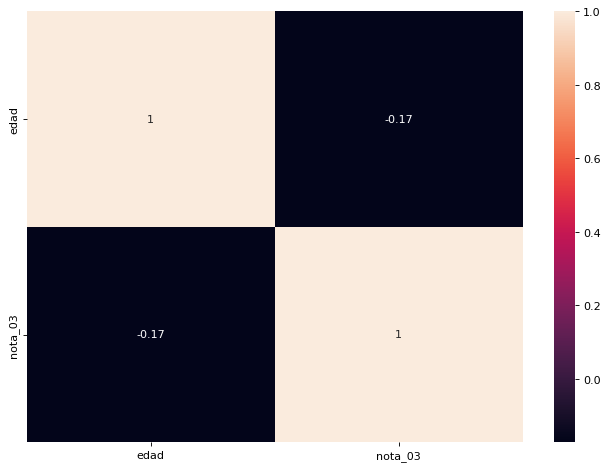

In [222]:
from matplotlib.pyplot import figure
dfaux = dfcd[['edad', 'nota_03']]
figure(figsize=(10, 7), dpi=80);
sns.heatmap(dfaux.corr(), annot = True);

In [223]:
fig = px.box(dfcd,
             x='edad',
             y='nota_03',
             color='edad')

fig.update_layout(
    title_text='Distribucion de las notas de los estudiantes segun su edad',
    xaxis=dict(
        title='edad estudiantes',
        titlefont_size=16
    ),
    yaxis=dict(
        title='Nota estudiantes',
        titlefont_size=16
    ),
    template='simple_white'
)
fig.show()

Como podemos notar en las gráficas anteriores, no se puede reconocer una correlación clara entre la variable independiente (edad del estudiante) y la variable dependiente (nota del estudiante), debido a que hay una correlación muy baja en el mapa de calor, y en las siguientes 2 variables no se puede apreciar un cambio considerable en el comportamiento a medida que cambia la edad, a excepción de los 20, 21 y 22 años, pero debemos tener en cuenta que estos datos son atípico ya que solo contienen 3, 1 y 1 registro, respectivamente.

**Tiempo primer examen vs Nota 3**

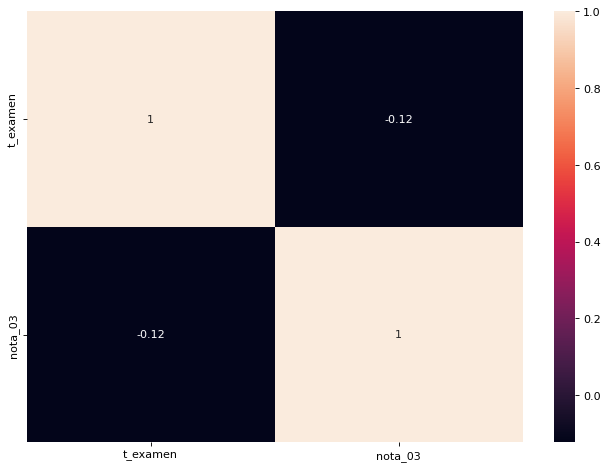

In [224]:
from matplotlib.pyplot import figure
df_aux = dfcd[['t_examen', 'nota_03']]
figure(figsize=(10, 7), dpi=80);
sns.heatmap(df_aux.corr(), annot = True);

In [225]:
fig = make_subplots(rows=1, cols=2)

nota_by_time = dfcd.groupby('t_examen')['nota_03'].median().sort_values(ascending=True)
nota_by_1 = dfcd.loc[dfcd['t_examen']== 1]
nota_by_2 = dfcd.loc[dfcd['t_examen']== 2]
nota_by_3 = dfcd.loc[dfcd['t_examen']== 3]
nota_by_4 = dfcd.loc[dfcd['t_examen']== 4]

colors=['coral', 'orangered', 'salmon', 'maroon']

fig.add_trace(
    go.Bar(
        x = ['1', '2', '3', '4'],
        y = nota_by_time.values,
        name = 'Bar Chart',
        marker_color = colors,
        text = np.round(nota_by_time.values)),
    row = 1, col = 1
)

fig.add_trace(
    go.Box(y = nota_by_1['nota_03'], name = '1', marker_color = 'coral'),
    row = 1, col = 2
)

fig.add_trace(
    go.Box(y = nota_by_2['nota_03'], name = '2', marker_color = 'orangered'),
    row = 1, col = 2
)

fig.add_trace(
    go.Box(y = nota_by_3['nota_03'], name = '3', marker_color = 'salmon'),
    row = 1, col = 2
)

fig.add_trace(
    go.Box(y = nota_by_4['nota_03'], name = '4', marker_color = 'maroon'),
    row = 1, col = 2
)

fig.update_layout(title_text="Nota promedio según el tiempo del primer examen", template='simple_white')
fig.show()

El comportamiento de esta variable respecto a la nota tres es incosistente ya que al mirar el boxplot muestra que entre más bajo sea el tiempo del primer examen, mejor nota tendrá el estudiante lo cual en la práctica no suele ser así. Al mirar el diagrama de correlación entre la nota 3 y el tiempo de primer examen esta relación es poco fuerte pero nos indica que es negativa, por lo que afirma que tienen una relació inversa. Estas razones nos llevan a creer que esta variable no explicaría de manera coherente los resultados de las califiaciones, por lo que no se tendrá en cuenta para el modelo.

**Tiempo de estudio semanal vs Nota 3**

In [226]:
fig = px.box(dfcd,
             x='t_estudio',
             y='nota_03',
             color='t_estudio')

fig.update_layout(
    title_text='Distribución de la nota 3 según el tiempo de estudio semanal',
    xaxis=dict(
        title='Tiempo',
        titlefont_size=16
    ),
    yaxis=dict(
        title='Mean nota 3',
        titlefont_size=16
    ),
    template='simple_white'
)
fig.show()

A medida que se va teniendo mayor tiempo de estudio entre semana el rango intercuartilico va adaptando una proporción a mejores notas, así como la media va creciendo. Podemos afirmar que entre más tiempo se dedique al estudio se tendrá una buena nota, sin embargo para las personas que estudian más de 10 horas las notas suelen ser parecidas a las personas que estudian de 5 a 10 horas, por lo que al estudiar por largos periodos de tiempo en la semana no puede asegurar una mejor nota. Esta variable será tenida en cuenta para la elaboración del modelo.

**Número de faltas a clases vs Nota 3**

In [227]:
fig = px.box(dfcd,
             x='faltas',
             y='nota_03',
             color='faltas')

fig.update_layout(
    title_text='Distribución de la nota 3 según las faltas a clases',
    xaxis=dict(
        title='Faltas',
        titlefont_size=16
    ),
    yaxis=dict(
        title='Mean nota 3',
        titlefont_size=16
    ),
    template='simple_white'
)
fig.show()

Al analizar el diagrama de lineas como el diagrama de cajas y bigotes, el comportamiento de las faltas a clases con la nota 3 es directamente proporcional, a mayor faltas a clases el estudiante obtendrá notas más bajas, aunque no faltar a clases no asegura tener mejores notas ya que en todas las categorías hay estudiantes que tiene notas muy bajas (Atipicos). Esta variable será incluida en el modelo.

**Nota 3 vs calidad de relaciones familiares**

In [228]:
proporcion(dfcd,'relacion_fam','relación con la familia')

-----------------------
relación con la familia 

4: 49.62%
5: 26.7%
3: 17.13%
2: 4.53%
1: 2.02%
-----------------------


In [229]:
fig = px.box(dfcd,
             x='relacion_fam',
             y='nota_03',
             color='relacion_fam')

fig.update_layout(
    title_text='Distribución de la nota 3 según la calidad de la relacion familiar',
    xaxis=dict(
        title='Calidad',
        titlefont_size=16
    ),
    yaxis=dict(
        title='Mean nota 3',
        titlefont_size=16
    ),
    template='simple_white'
)
fig.show()
print("1:Muy mala, 2:Regular, 3:Buena, 4:Muy buena, 5:Excelente")

1:Muy mala, 2:Regular, 3:Buena, 4:Muy buena, 5:Excelente


Logramos ver como la calidad de relaciones familiares puede de cierta forma afectar el rendimiento del estudiante, vemos un comportamiento que tiene mucha lógica ya que entre mejor sea esta relación mayores notas se pueden obtener, se incluira esta variable en el modelo

**Nota 3 vs tiempo libre despues de la universidad**

In [230]:
fig = px.box(dfcd,
             x='tiempo_libre',
             y='nota_03',
             color='tiempo_libre')

fig.update_layout(
    title_text='Distribución de la nota 3 según el tiempo libre despues de clases',
    xaxis=dict(
        title='Tiempo libre',
        titlefont_size=16
    ),
    yaxis=dict(
        title='Mean nota 3',
        titlefont_size=16
    ),
    template='simple_white'
)
fig.show()
print("1:Muy bajo, 2:Bajo, 3:Regular, 4:Alto, 5:Muy alto")

1:Muy bajo, 2:Bajo, 3:Regular, 4:Alto, 5:Muy alto


A partir del grafico vemos como tienden a tener mejores notas los estudiantes que no cuentan con mucho tiempo libre, se podria ver como entre mas ocupados se dedican mas a estudiar para sus parciales, esta variable esta balanceada por lo que la incluiremos

**Salidas con amigos vs Nota 3**

In [231]:
fig = make_subplots(rows=1, cols=2)

nota_amigos = dfcd.groupby('salir_amigos')['nota_03'].mean()
salir_1 = dfcd.loc[dfcd['salir_amigos']== 1]
salir_2 = dfcd.loc[dfcd['salir_amigos']== 2]
salir_3 = dfcd.loc[dfcd['salir_amigos']== 3]
salir_4 = dfcd.loc[dfcd['salir_amigos']== 4]
salir_5 = dfcd.loc[dfcd['salir_amigos']== 5]


colors=['orangered', 'green', 'purple', 'orange','blue']

fig.add_trace(
    go.Bar(
        x=['1', '2', '3', '4','5'],
        y=nota_amigos.values,
        name='Bar Chart',
        text=np.round(nota_amigos.values),
        marker_color=colors),
    row=1, col=1
)

fig.add_trace(
    go.Box(y=salir_1['nota_03'], name='1'),
    row=1, col=2
)

fig.add_trace(
    go.Box(y=salir_2['nota_03'], name='2'),
    row=1, col=2
)

fig.add_trace(
    go.Box(y=salir_3['nota_03'], name='3'),
    row=1, col=2
)

fig.add_trace(
    go.Box(y=salir_4['nota_03'], name='4'),
    row=1, col=2
)

fig.add_trace(
    go.Box(y=salir_5['nota_03'], name='5'),
    row=1, col=2
)

fig.update_layout(
    title_text="Nota promedio según grado de salidas con amigos",
    template='simple_white')
fig.show()

Basándonos en el gráfico de barras, podemos notar que pareciera que mientras el nivel de salidas con amigos aumenta, la nota promedio de los estudiantes va disminuyendo. En el gráfico boxplot observamos que el rango intercuartílico para un estudiante que sale mucho con sus amigos (5) es mucho mayor que el resto. Los cuartiles 1 y 3 de este mismo nivel corresponden a notas de 6 y 12, esto indica que el 50% de los estudiantes que salen mucho con sus amigos pierden.

Por esta razón, incluiremos esta variable en nuestro modelo.

**Consumo de alcohol entre semana vs Nota 3**

In [232]:
fig = make_subplots(rows=1, cols=2)

nota_alcoholsem = dfcd.groupby('cons_alcohol_sem')['nota_03'].mean()
alcoholsem_1 = dfcd.loc[dfcd['cons_alcohol_sem']== 1]
alcoholsem_2 = dfcd.loc[dfcd['cons_alcohol_sem']== 2]
alcoholsem_3 = dfcd.loc[dfcd['cons_alcohol_sem']== 3]
alcoholsem_4 = dfcd.loc[dfcd['cons_alcohol_sem']== 4]
alcoholsem_5 = dfcd.loc[dfcd['cons_alcohol_sem']== 5]


colors=['orangered', 'green', 'purple', 'orange','blue']

fig.add_trace(
    go.Bar(
        x=['1', '2', '3', '4','5'],
        y=nota_alcoholsem.values,
        name='Bar Chart',
        text=np.round(nota_alcoholsem.values),
        marker_color=colors),
    row=1, col=1
)

fig.add_trace(
    go.Box(y=alcoholsem_1['nota_03'], name='1'),
    row=1, col=2
)

fig.add_trace(
    go.Box(y=alcoholsem_2['nota_03'], name='2'),
    row=1, col=2
)

fig.add_trace(
    go.Box(y=alcoholsem_3['nota_03'], name='3'),
    row=1, col=2
)

fig.add_trace(
    go.Box(y=alcoholsem_4['nota_03'], name='4'),
    row=1, col=2
)

fig.add_trace(
    go.Box(y=alcoholsem_5['nota_03'], name='5'),
    row=1, col=2
)

fig.update_layout(
    title_text="Nota promedio según consumo de alcohol a la semana",
    template='simple_white')
fig.show()


Según el gráfico de barras observado anteriormente, no es muy clara la relación que existe entre la nota promedio del estudiantado y el consumo de alcohol semanal.

En el gráfico de boxplottanto los que consumen grados de alcohol de 1,2,3,4 y 5 tiene la misma mediana (menor a la nota de aprobación). Esto implicaría que según esta medida de tendencia central, tanto los que consumen mucho como los que consumen poco alcohol a la semana obtienen un resultado similar en su examen 3.

Lo anterior parece darnos indicios de que la no significancia de la variable, razón por la cual NO será incluida en el modelo.

**Consumo de alcohol fines de semana vs Nota 3**

In [233]:
fig = make_subplots(rows=1, cols=2)

nota_alcoholsem = dfcd.groupby('cons_alcohol_finde')['nota_03'].mean()
alcoholsem_1 = dfcd.loc[dfcd['cons_alcohol_finde']== 1]
alcoholsem_2 = dfcd.loc[dfcd['cons_alcohol_finde']== 2]
alcoholsem_3 = dfcd.loc[dfcd['cons_alcohol_finde']== 3]
alcoholsem_4 = dfcd.loc[dfcd['cons_alcohol_finde']== 4]
alcoholsem_5 = dfcd.loc[dfcd['cons_alcohol_finde']== 5]


colors=['orangered', 'green', 'purple', 'orange','blue']

fig.add_trace(
    go.Bar(
        x=['1', '2', '3', '4','5'],
        y=nota_alcoholsem.values,
        name='Bar Chart',
        text=np.round(nota_alcoholsem.values),
        marker_color=colors),
    row=1, col=1
)

fig.add_trace(
    go.Box(y=alcoholsem_1['nota_03'], name='1'),
    row=1, col=2
)

fig.add_trace(
    go.Box(y=alcoholsem_2['nota_03'], name='2'),
    row=1, col=2
)

fig.add_trace(
    go.Box(y=alcoholsem_3['nota_03'], name='3'),
    row=1, col=2
)

fig.add_trace(
    go.Box(y=alcoholsem_4['nota_03'], name='4'),
    row=1, col=2
)

fig.add_trace(
    go.Box(y=alcoholsem_5['nota_03'], name='5'),
    row=1, col=2
)

fig.update_layout(
    title_text="Nota promedio según consumo de alcohol en fin de semana",
    template='simple_white')
fig.show()


En este caso, tampoco parece haber una relación muy clara en cuato al nivel de consumo de alcohol de los estudiantes y su nota promedio en el examen 3. Según la medianas observadas en el boxplot, tanto los que consumen como los que no consumen pierden el examen.

Por esta razón NO será incluida esta variable en el modelo de regresión lineal.

**Salud vs Nota 3**

In [234]:
# Calcular la mediana de las notas del tercer examen según el estado de salud
base = dfcd.groupby(['salud'])[['nota_03']].mean().reset_index().sort_values('salud',ascending=True)
# Gráfico de caja
fig2 = px.box(dfcd, x='salud', y='nota_03', title='<b>Nota del estudiante según su estado de salud<b>')

fig2.show()

En el boxplot pareciera que a medida que el estado de salud aumenta, las notas tienden a disminuir.

In [235]:
base = dfcd.groupby(['salud'])[['nota_03']].mean().reset_index().sort_values('salud', ascending = True)

# crear gráfica
fig = px.bar(base, x='salud', y='nota_03', barmode ='group', title ='<b>Nota promedio según estado de salud<b>')

# agregar detalles a la gráfica
fig.update_layout(
    xaxis_title = 'Estado de salud',
    yaxis_title = 'Nota promedio en el examen 3',
    template = 'simple_white',
    title_x = 0.5)

fig.show()

Veamos que en promedio, los estudiantes con peor estado de salud, obtienen una mejor nota en el examen 3 comparados con quienes tienen un estado de salud muy bueno. Adicional, vemos que en los niveles (2,3,4 y 5) hay un promedio muy similar.

Esto parece indicarnos que NO existe una significancia importante del estado de salud con respecto a las notas promedio de los estudiantes.

**Ausencias vs Nota 3**

In [236]:
base = dfcd.groupby(['ausencias'])[['nota_03']].mean().reset_index().sort_values('ausencias', ascending=True)
base

fig = px.scatter(base, x='ausencias', y='nota_03', title='<b>Nota promedio según ausencias a la universidad<b>')

fig.show()


En el diagrama de correlación no se logra captar muy bien la relación existente entre ambas variables. Se nota un poco una tendencia decreciente, pero no es muy clara puesto que se observa mucha variabilidad en los datos.

Dado que estamos ante una variable numérica, vamos a observar los valores de correlación entre estas variables.

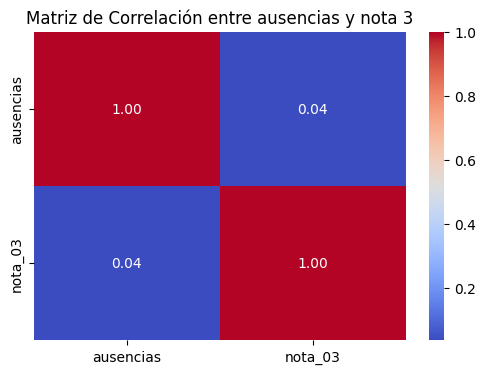

In [237]:
correlation_matrix = dfcd[['ausencias', 'nota_03']].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

plt.title("Matriz de Correlación entre ausencias y nota 3")

plt.show()


Notamos una correlación baja entre el nivel de ausencias y la nota del examen 3. También debemos tener en cuenta que la variable ausencias implica ausentismo a la universidad, mas no a la clase. Es posible que el estudiante se haya ausentado a la universidad un día que no tuvo clase de cálculo diferencial.

Por estas razones no vamos a incluir esta variable en el modelo.

**Nota 1 vs Nota 3**

In [238]:
base = dfcd.groupby(['nota_01'])[['nota_03']].mean().reset_index().sort_values(['nota_01'],ascending=True)
fig = px.scatter(base, x='nota_01',y='nota_03')
fig.add_trace(go.Scatter(x=base['nota_01'], y=base['nota_03'], mode='markers', name='Nota promedio tercer examen'))
fig.show()

Es evidente que a medida que la nota del examen 1 aumenta, la nota del examen 3 también aumente. Esto tiene mucho sentido para una materia como el cálculo diferencial en el cual el primer parcial es básicamente funciones y el último es derivadas. Quien no sepa funciones, mucho menos va a ser capaz de derivarlas.

In [239]:
condicion_ganar = base['nota_01'] >= 12
condicion_perder = base['nota_01'] < 12

base['Resultado_Examen1'] = 0
base.loc[condicion_ganar, 'Resultado_Examen1'] = 'Ganó'
base.loc[condicion_perder,'Resultado_Examen1'] = 'Perdió'
display(base)

fig = px.box(base, x='Resultado_Examen1',y='nota_03')
fig.show()


,nota_01,nota_03,Resultado_Examen1
0,3,5.000000,Perdió
1,4,0.000000,Perdió
2,5,4.625000,Perdió
3,6,4.040000,Perdió
4,7,5.594595,Perdió
5,8,8.121951,Perdió
6,9,8.064516,Perdió
7,10,9.254902,Perdió
8,11,10.743590,Perdió
9,12,11.971429,Ganó


Es más que evidente que quienes pierden el primero, en promedio también pierden el tercero. Así mismo, quienes ganan el primero también ganan el tercero.

**Nota 2 vs Nota 3**

In [240]:
base = dfcd.groupby(['nota_02'])[['nota_03']].mean().reset_index().sort_values(['nota_02'],ascending=True)
fig = px.scatter(base, x='nota_02',y='nota_03')
fig.add_trace(go.Scatter(x=base['nota_02'], y=base['nota_03'], mode='markers', name='Nota promedio tercer examen'))
fig.show()

Para la nota 2 y la nota 3 es mucho más evidente esa relación de incremento en la nota 3 a medida que aumenta la nota del examen 2.

Claramente, vamos a dejar esta variable incluida en el modelo.

**Nota 1 y Nota 2**

Acabamos de ver que tanto la nota 2 como la nota 1 son relevantes para el
modelo. En la vida real, un estudiante guía su trasegar académico por su promedio, razón por la cual vamos a promediar estas dos columnas; esto también con la intención de evitar problemas de multicolinealidad en el modelo que se evidencian a continuación:

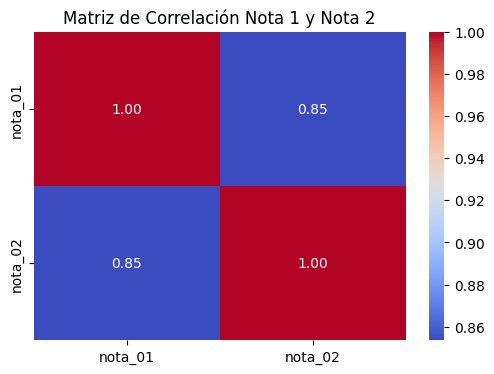

In [241]:
correlation_matrix = dfcd[['nota_01', 'nota_02']].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

plt.title("Matriz de Correlación Nota 1 y Nota 2")

plt.show()


#Selección de variables

Durante el proceso de preparacion de los datos se argumentaron las razones por las cuales se dejaran algunas variables y se excluirán otras. A continuación dividimos el dataset entre variables predictoras y variable a predecir basados en esto.

In [242]:
dfcd.columns

Index(['departamento', 'sexo', 'edad', 'direccion', 't_familia',
       'padres_status', 'madre_edu', 'padre_edu', 'madre_trab', 'padre_trab',
       'razon', 'guardian', 't_examen', 't_estudio', 'faltas',
       'soporte_edu_extra', 'soporte_edu_fam', 'monitores',
       'actividades_extra', 'preuniversitario', 'postgrado', 'internet',
       'relacion_sen', 'relacion_fam', 'tiempo_libre', 'salir_amigos',
       'cons_alcohol_sem', 'cons_alcohol_finde', 'salud', 'ausencias',
       'nota_01', 'nota_02', 'nota_03', 'padres_edu'],
      dtype='object')

In [243]:
y_target = dfcd['nota_03']
X_features = dfcd.drop(['departamento', 't_familia', 'padres_status', 'razon', 'soporte_edu_extra', 'soporte_edu_fam', 'monitores',
       'actividades_extra', 'preuniversitario', 'postgrado', 'edad', 'cons_alcohol_sem', 't_examen', 'salud', 'ausencias', 'nota_03'], axis=1, inplace=False)

In [244]:
X_features

,sexo,direccion,madre_edu,padre_edu,madre_trab,padre_trab,guardian,t_estudio,faltas,internet,relacion_sen,relacion_fam,tiempo_libre,salir_amigos,cons_alcohol_finde,nota_01,nota_02,padres_edu
0,M,U,4,4,en_casa,profesor,madre,2,0,no,no,4,3,4,1,5,6,4.0
1,M,U,1,1,en_casa,otro,padre,2,0,si,no,5,3,3,1,5,5,1.0
2,M,U,1,1,en_casa,otro,madre,2,3,si,no,4,3,2,3,7,8,1.0
3,M,U,4,2,salud,servicios,madre,3,0,si,si,3,2,2,1,15,14,3.0
4,M,U,3,3,otro,otro,padre,2,0,no,no,4,3,2,2,6,10,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,H,R,1,1,otro,otro,otro,1,3,no,no,5,5,3,3,10,8,1.0
393,H,R,3,2,servicios,otro,madre,1,0,si,no,4,4,1,4,11,12,2.5
394,H,U,1,1,otro,en_casa,padre,1,0,si,no,3,2,3,3,8,9,1.0
395,M,U,4,4,en_casa,profesor,madre,2,0,no,no,4,3,4,1,5,6,4.0


In [245]:
X_features.columns.values

array(['sexo', 'direccion', 'madre_edu', 'padre_edu', 'madre_trab',
       'padre_trab', 'guardian', 't_estudio', 'faltas', 'internet',
       'relacion_sen', 'relacion_fam', 'tiempo_libre', 'salir_amigos',
       'cons_alcohol_finde', 'nota_01', 'nota_02', 'padres_edu'],
      dtype=object)

#**Transformación de variables**

En este caso, unicamente vamos a unir la nota del examen 1 y la nota del examen 2 promediándolos.

In [246]:
# Promedio acumulado nota 1 y nota 2
X_features['promedio_acumulado'] = (X_features['nota_01'] + X_features['nota_02']) / 2


In [247]:
X_features

,sexo,direccion,madre_edu,padre_edu,madre_trab,padre_trab,guardian,t_estudio,faltas,internet,relacion_sen,relacion_fam,tiempo_libre,salir_amigos,cons_alcohol_finde,nota_01,nota_02,padres_edu,promedio_acumulado
0,M,U,4,4,en_casa,profesor,madre,2,0,no,no,4,3,4,1,5,6,4.0,5.5
1,M,U,1,1,en_casa,otro,padre,2,0,si,no,5,3,3,1,5,5,1.0,5.0
2,M,U,1,1,en_casa,otro,madre,2,3,si,no,4,3,2,3,7,8,1.0,7.5
3,M,U,4,2,salud,servicios,madre,3,0,si,si,3,2,2,1,15,14,3.0,14.5
4,M,U,3,3,otro,otro,padre,2,0,no,no,4,3,2,2,6,10,3.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,H,R,1,1,otro,otro,otro,1,3,no,no,5,5,3,3,10,8,1.0,9.0
393,H,R,3,2,servicios,otro,madre,1,0,si,no,4,4,1,4,11,12,2.5,11.5
394,H,U,1,1,otro,en_casa,padre,1,0,si,no,3,2,3,3,8,9,1.0,8.5
395,M,U,4,4,en_casa,profesor,madre,2,0,no,no,4,3,4,1,5,6,4.0,5.5


Después de realizar la transformación de variables y unir aquellas que consideramos pueden simplificarse en una sola, eliminamos las variables individuales.

In [248]:
X_features = X_features.drop(['madre_edu', 'padre_edu', 'nota_01', 'nota_02'], axis=1, inplace=False)

In [249]:
X_features

,sexo,direccion,madre_trab,padre_trab,guardian,t_estudio,faltas,internet,relacion_sen,relacion_fam,tiempo_libre,salir_amigos,cons_alcohol_finde,padres_edu,promedio_acumulado
0,M,U,en_casa,profesor,madre,2,0,no,no,4,3,4,1,4.0,5.5
1,M,U,en_casa,otro,padre,2,0,si,no,5,3,3,1,1.0,5.0
2,M,U,en_casa,otro,madre,2,3,si,no,4,3,2,3,1.0,7.5
3,M,U,salud,servicios,madre,3,0,si,si,3,2,2,1,3.0,14.5
4,M,U,otro,otro,padre,2,0,no,no,4,3,2,2,3.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,H,R,otro,otro,otro,1,3,no,no,5,5,3,3,1.0,9.0
393,H,R,servicios,otro,madre,1,0,si,no,4,4,1,4,2.5,11.5
394,H,U,otro,en_casa,padre,1,0,si,no,3,2,3,3,1.0,8.5
395,M,U,en_casa,profesor,madre,2,0,no,no,4,3,4,1,4.0,5.5


**Encoders**

Realizamos una transformación adicional para hacer el tratamiento de las variables categóricas.

In [250]:
X_features = pd.get_dummies(X_features)

In [251]:
X_features

,t_estudio,faltas,relacion_fam,tiempo_libre,salir_amigos,cons_alcohol_finde,padres_edu,promedio_acumulado,sexo_H,sexo_M,direccion_R,direccion_U,madre_trab_en_casa,madre_trab_otro,madre_trab_profesor,madre_trab_salud,madre_trab_servicios,padre_trab_en_casa,padre_trab_otro,padre_trab_profesor,padre_trab_salud,padre_trab_servicios,guardian_madre,guardian_otro,guardian_padre,internet_no,internet_si,relacion_sen_no,relacion_sen_si
0,2,0,4,3,4,1,4.0,5.5,0,1,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0
1,2,0,5,3,3,1,1.0,5.0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0
2,2,3,4,3,2,3,1.0,7.5,0,1,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0
3,3,0,3,2,2,1,3.0,14.5,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,1
4,2,0,4,3,2,2,3.0,8.0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,1,3,5,5,3,3,1.0,9.0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0
393,1,0,4,4,1,4,2.5,11.5,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0
394,1,0,3,2,3,3,1.0,8.5,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0
395,2,0,4,3,4,1,4.0,5.5,0,1,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0


**Escalado**

In [252]:
# Función para realizar escalado de variables
def escalado(dataframe, column):
  dataframe[column] = (dataframe[column] - dataframe[column].min())/(dataframe[column].max() - dataframe[column].min())

In [253]:
escalado(X_features, 't_estudio')
escalado(X_features, 'faltas')
escalado(X_features, 'relacion_fam')
escalado(X_features, 'tiempo_libre')
escalado(X_features, 'salir_amigos')
escalado(X_features, 'cons_alcohol_finde')
escalado(X_features, 'padres_edu')
escalado(X_features, 'promedio_acumulado')

X_features

,t_estudio,faltas,relacion_fam,tiempo_libre,salir_amigos,cons_alcohol_finde,padres_edu,promedio_acumulado,sexo_H,sexo_M,direccion_R,direccion_U,madre_trab_en_casa,madre_trab_otro,madre_trab_profesor,madre_trab_salud,madre_trab_servicios,padre_trab_en_casa,padre_trab_otro,padre_trab_profesor,padre_trab_salud,padre_trab_servicios,guardian_madre,guardian_otro,guardian_padre,internet_no,internet_si,relacion_sen_no,relacion_sen_si
0,0.333333,0.000000,0.75,0.50,0.75,0.00,1.000000,0.205882,0,1,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0
1,0.333333,0.000000,1.00,0.50,0.50,0.00,0.142857,0.176471,0,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0
2,0.333333,1.000000,0.75,0.50,0.25,0.50,0.142857,0.323529,0,1,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0
3,0.666667,0.000000,0.50,0.25,0.25,0.00,0.714286,0.735294,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,1
4,0.333333,0.000000,0.75,0.50,0.25,0.25,0.714286,0.352941,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,0.000000,1.000000,1.00,1.00,0.50,0.50,0.142857,0.411765,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0
393,0.000000,0.000000,0.75,0.75,0.00,0.75,0.571429,0.558824,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0
394,0.000000,0.000000,0.50,0.25,0.50,0.50,0.142857,0.382353,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0
395,0.333333,0.000000,0.75,0.50,0.75,0.00,1.000000,0.205882,0,1,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0


**DIVISIÓN TRAIN/TEST**

Dividimos el dataset en train y test

In [254]:
X_features.shape

(397, 29)

In [255]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.3, random_state = 156)

**Modelos**

Vamos a implementar un modelo de regresión lineal múltiple para estimar la nota 3 de los estudiantes.

In [256]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

LinearRegression()

**train**

In [257]:
lr_pred = lr_reg.predict(X_train)

In [258]:
# Metricas
print("MSE: %.2f" % mean_squared_error(y_train, lr_pred))
print("RMSE %.2f" % math.sqrt(mean_squared_error(y_train, lr_pred)))
print("MAE: %.2f" % mean_absolute_error(y_train, lr_pred))
print("MAPE: %.2f" % mean_absolute_percentage_error(y_train, lr_pred))
print("R2: %.2f" % r2_score(y_train, lr_pred))

# R2 ajustado
r2 = r2_score(y_train, lr_pred)
adj_r2 = 1 - (1-r2)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
print("R2-adjusted: %.2f" % adj_r2)

MSE: 3.73
RMSE 1.93
MAE: 1.32
MAPE: 1767077454998214.75
R2: 0.81
R2-adjusted: 0.79


Basándonos principalmente en el R2-ajustado, se observa que el 79% de la variabilidad de la nota 3 de los estudiantes es explicada por las variables seleccionadas.

**Test**

Realizamos las predicciones para el conjunto de datos de test.

In [259]:
lr_pred = lr_reg.predict(X_test)
lr_pred

array([11.22529013,  4.21310508, 10.4359189 , 11.12959832, 12.02098239,
       11.34011598,  7.72220212, 12.5301371 ,  3.99611948,  9.13104675,
        4.57985172,  9.83408364,  8.37821542,  0.58207001,  3.97431969,
       12.79772606,  3.67427551,  9.76292209, 18.01890075,  5.96509125,
        9.33234813, 10.78922406, 14.79058781,  8.04502487, 20.17970462,
       10.60403208,  4.06224866,  7.79366222,  8.85169405,  2.89604638,
        9.12951358, 15.93065003,  7.62100843,  5.9427493 , 12.57502967,
        3.82435474,  5.48935636, 11.60038976, 13.68897946,  9.04630682,
       13.6281918 , 10.64870177,  6.47292807, 13.30573554, 11.08875896,
        2.42232654,  4.21674838, 17.95413732, -0.62205292, 10.56994259,
        6.09542764, 13.0692805 ,  3.96835966, 13.92196017, 12.37688332,
       10.76562771, 11.8589915 , 10.63369093, 11.28144201, 14.4148192 ,
        9.684984  ,  7.36637512, 12.45040409,  2.39953666, 11.25209526,
        4.62776714, 17.3265051 , 13.64466907,  6.43373229, 12.58

In [260]:
# Metricas
print("MSE: %.2f" % mean_squared_error(y_test, lr_pred))
print("RMSE %.2f" % math.sqrt(mean_squared_error(y_test, lr_pred)))
print("MAE: %.2f" % mean_absolute_error(y_test, lr_pred))
print("MAPE: %.2f" % mean_absolute_percentage_error(y_test, lr_pred))
print("R2: %.2f" % r2_score(y_test, lr_pred))

# R2 ajustado
r2 = r2_score(y_test, lr_pred)
adj_r2 = 1 - (1-r2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
print("R2-adjusted: %.2f" % adj_r2)

MSE: 5.39
RMSE 2.32
MAE: 1.56
MAPE: 2808212158920265.50
R2: 0.76
R2-adjusted: 0.69


Hay una disminución en el R2-Ajustado, esto puede deberse a que le conjunto de datos en el entrenamiento es mucho mayor que el conjunto de datos del test. No obstante, se descata que casi el 70% de la variabilidad de la nota del examen 3 es explicada por las variables seleccionadas.

Tambien observamos que las metricas desmejoraron comparadas con el entrenamiento, sin embargo este es un comportamiento que podriamos esperar ya que el modelo puede adaptarse mejor a las variables de entrenamiento, las aprende mejor y al ingresarle nuevos datos es un poco menos acertado

In [261]:
resultados = pd.DataFrame(lr_pred)
resultados.rename(columns={0:'Predicción'},inplace=True)
resultados

condicion_ganar = resultados['Predicción'] >= 12
condicion_perder = resultados['Predicción'] < 12

resultados.loc[condicion_ganar, 'Condición_academica'] = 'Ganó'
resultados.loc[condicion_perder,'Condición_academica'] = 'Perdió'
display(resultados)

,Predicción,Condición_academica
0,11.225290,Perdió
1,4.213105,Perdió
2,10.435919,Perdió
3,11.129598,Perdió
4,12.020982,Ganó
...,...,...
115,8.965143,Perdió
116,15.000582,Ganó
117,8.546334,Perdió
118,11.848807,Perdió


In [262]:
base = resultados.groupby(['Condición_academica'])['Predicción'].count().reset_index().sort_values('Predicción', ascending = False).rename(columns ={'Predicción':'count'})

cant_ed = resultados['Condición_academica'].count()

# hacer la gráfica
fig = px.pie(base , values = 'count', names = 'Condición_academica', title = '<b>Condición académica<b>',
             hole = .5)

# poner detalles a la gráfica
fig.update_layout(
    template = 'simple_white',
    legend_title = '<b>Condición<b>',
    title_x = 0.5,
    annotations = [dict(text = 'Muestras:<br>'+str(cant_ed), x=0.5, y = 0.5, font_size = 20, showarrow = False)])

fig.show()

Finalmente, llegamos a la conclusión que con nuestro modelo predictivo, aproximadamente el 70% de los estudiantes estarían perdiendo cálculo diferencial.

#División del dataset y modelo de regresión lineal con las variables originales de la base de datos#

In [263]:
#Utilizamos pandas para leer el dataset importado desde Github
dfavcompleta = pd.read_csv(urlcal, index_col=[0])
dfavcompleta.head(3)

,departamento,sexo,edad,direccion,t_familia,padres_status,madre_edu,padre_edu,madre_trab,padre_trab,razon,guardian,t_examen,t_estudio,faltas,soporte_edu_extra,soporte_edu_fam,monitores,actividades_extra,preuniversitario,postgrado,internet,relacion_sen,relacion_fam,tiempo_libre,salir_amigos,cons_alcohol_sem,cons_alcohol_finde,salud,ausencias,nota_01,nota_02,nota_03
0,II,M,18,U,mayor_3,S,4,4,en_casa,profesor,habilidad,madre,2,2,0,si,no,no,no,si,si,no,no,4,3,4,1,1,3,6,5,6,6
1,II,M,17,U,mayor_3,J,1,1,en_casa,otro,habilidad,padre,1,2,0,no,si,no,no,no,si,yes,no,5,3,3,1,1,3,4,5,5,6
2,II,M,15,U,menor_e3,J,1,1,en_casa,otro,otro,madre,1,2,3,si,no,si,no,si,si,yes,no,4,3,2,2,3,3,10,7,8,10


**Encoders**

In [264]:
X_featuresc = dfavcompleta.drop(['nota_03'], axis=1, inplace=False)
X_featuresc

,departamento,sexo,edad,direccion,t_familia,padres_status,madre_edu,padre_edu,madre_trab,padre_trab,razon,guardian,t_examen,t_estudio,faltas,soporte_edu_extra,soporte_edu_fam,monitores,actividades_extra,preuniversitario,postgrado,internet,relacion_sen,relacion_fam,tiempo_libre,salir_amigos,cons_alcohol_sem,cons_alcohol_finde,salud,ausencias,nota_01,nota_02
0,II,M,18,U,mayor_3,S,4,4,en_casa,profesor,habilidad,madre,2,2,0,si,no,no,no,si,si,no,no,4,3,4,1,1,3,6,5,6
1,II,M,17,U,mayor_3,J,1,1,en_casa,otro,habilidad,padre,1,2,0,no,si,no,no,no,si,yes,no,5,3,3,1,1,3,4,5,5
2,II,M,15,U,menor_e3,J,1,1,en_casa,otro,otro,madre,1,2,3,si,no,si,no,si,si,yes,no,4,3,2,2,3,3,10,7,8
3,II,M,15,U,mayor_3,J,4,2,salud,servicios,recomendacion,madre,1,3,0,no,si,si,si,si,si,yes,yes,3,2,2,1,1,5,2,15,14
4,II,M,16,U,mayor_3,J,3,3,otro,otro,recomendacion,padre,1,2,0,no,si,si,no,si,si,no,no,4,3,2,1,2,5,4,6,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,MS,H,21,R,mayor_3,J,1,1,otro,otro,habilidad,otro,1,1,3,no,no,no,no,no,si,no,no,5,5,3,3,3,3,3,10,8
393,MS,H,18,R,menor_e3,J,3,2,servicios,otro,habilidad,madre,3,1,0,no,no,no,no,no,si,yes,no,4,4,1,3,4,5,0,11,12
394,MS,H,19,U,menor_e3,J,1,1,otro,en_casa,habilidad,padre,1,1,0,no,no,no,no,si,si,yes,no,3,2,3,3,3,5,5,8,9
395,II,M,18,U,mayor_3,S,4,4,en_casa,profesor,habilidad,madre,2,2,0,si,no,no,no,si,si,no,no,4,3,4,1,1,3,6,5,6


In [265]:
X_featuresc=pd.get_dummies(X_featuresc)

**Escalado**

In [266]:
escalado(X_featuresc, 't_estudio')
escalado(X_featuresc, 'faltas')
escalado(X_featuresc, 'relacion_fam')
escalado(X_featuresc, 'tiempo_libre')
escalado(X_featuresc, 'madre_edu')
escalado(X_featuresc, 'padre_edu')
escalado(X_featuresc, 'cons_alcohol_finde')
escalado(X_featuresc, 'cons_alcohol_sem')
escalado(X_featuresc, 'nota_01')
escalado(X_featuresc, 'nota_02')
X_featuresc

,edad,madre_edu,padre_edu,t_examen,t_estudio,faltas,relacion_fam,tiempo_libre,salir_amigos,cons_alcohol_sem,cons_alcohol_finde,salud,ausencias,nota_01,nota_02,departamento_II,departamento_MS,sexo_H,sexo_M,direccion_R,direccion_U,t_familia_mayor_3,t_familia_menor_e3,padres_status_J,padres_status_S,madre_trab_en_casa,madre_trab_otro,madre_trab_profesor,madre_trab_salud,madre_trab_servicios,padre_trab_en_casa,padre_trab_otro,padre_trab_profesor,padre_trab_salud,padre_trab_servicios,razon_habilidad,razon_otro,razon_recomendacion,razon_reputacion,guardian_madre,guardian_otro,guardian_padre,soporte_edu_extra_no,soporte_edu_extra_si,soporte_edu_fam_no,soporte_edu_fam_si,monitores_no,monitores_si,actividades_extra_no,actividades_extra_si,preuniversitario_no,preuniversitario_si,postgrado_no,postgrado_si,internet_no,internet_yes,relacion_sen_no,relacion_sen_yes
0,18,1.00,1.00,2,0.333333,0.000000,0.75,0.50,4,0.00,0.00,3,6,0.1250,0.315789,1,0,0,1,0,1,1,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,1,0,1,0,0,1,0,1,1,0,1,0
1,17,0.25,0.25,1,0.333333,0.000000,1.00,0.50,3,0.00,0.00,3,4,0.1250,0.263158,1,0,0,1,0,1,1,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,1,1,0,1,0,1,0,0,1,0,1,1,0
2,15,0.25,0.25,1,0.333333,1.000000,0.75,0.50,2,0.25,0.50,3,10,0.2500,0.421053,1,0,0,1,0,1,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,1,1,0,0,1,0,1,0,1,1,0
3,15,1.00,0.50,1,0.666667,0.000000,0.50,0.25,2,0.00,0.00,5,2,0.7500,0.736842,1,0,0,1,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1
4,16,0.75,0.75,1,0.333333,0.000000,0.75,0.50,2,0.00,0.25,5,4,0.1875,0.526316,1,0,0,1,0,1,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,1,1,0,0,1,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,21,0.25,0.25,1,0.000000,1.000000,1.00,1.00,3,0.50,0.50,3,3,0.4375,0.421053,0,1,1,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0
393,18,0.75,0.50,3,0.000000,0.000000,0.75,0.75,1,0.50,0.75,5,0,0.5000,0.631579,0,1,1,0,1,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,1,0
394,19,0.25,0.25,1,0.000000,0.000000,0.50,0.25,3,0.50,0.50,5,5,0.3125,0.473684,0,1,1,0,0,1,0,1,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0,1,0,0,1,0,1,0,1,1,0
395,18,1.00,1.00,2,0.333333,0.000000,0.75,0.50,4,0.00,0.00,3,6,0.1250,0.315789,1,0,0,1,0,1,1,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,1,0,1,0,0,1,0,1,1,0,1,0


In [267]:
y_targetc = dfavcompleta['nota_03']

Ahora realizamos la división del dataset en train y test, destinando un 70% de los datos para training y un 30% para testing.

In [268]:
X_train, X_test, y_train, y_test = train_test_split(X_featuresc, y_targetc, test_size = 0.3, random_state = 156)

In [269]:
X_test

,edad,madre_edu,padre_edu,t_examen,t_estudio,faltas,relacion_fam,tiempo_libre,salir_amigos,cons_alcohol_sem,cons_alcohol_finde,salud,ausencias,nota_01,nota_02,departamento_II,departamento_MS,sexo_H,sexo_M,direccion_R,direccion_U,t_familia_mayor_3,t_familia_menor_e3,padres_status_J,padres_status_S,madre_trab_en_casa,madre_trab_otro,madre_trab_profesor,madre_trab_salud,madre_trab_servicios,padre_trab_en_casa,padre_trab_otro,padre_trab_profesor,padre_trab_salud,padre_trab_servicios,razon_habilidad,razon_otro,razon_recomendacion,razon_reputacion,guardian_madre,guardian_otro,guardian_padre,soporte_edu_extra_no,soporte_edu_extra_si,soporte_edu_fam_no,soporte_edu_fam_si,monitores_no,monitores_si,actividades_extra_no,actividades_extra_si,preuniversitario_no,preuniversitario_si,postgrado_no,postgrado_si,internet_no,internet_yes,relacion_sen_no,relacion_sen_yes
28,16,0.75,1.00,1,0.333333,0.000000,1.00,0.50,3,0.00,0.00,5,4,0.5000,0.578947,1,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,1,0,0,1,0,1,0,1,0,1,1,0
220,17,0.50,0.25,2,0.333333,0.000000,0.75,0.25,5,0.00,0.25,5,2,0.1875,0.315789,1,0,0,1,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,1,0,0,1,0,1,0,1,0,1,1,0
313,19,0.75,0.50,2,0.333333,0.333333,0.75,0.25,2,0.00,0.25,1,22,0.6250,0.526316,1,0,0,1,0,1,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,1,1,0,1,0,0,1,0,1,0,1
77,16,0.50,0.50,1,1.000000,0.000000,1.00,0.25,3,0.00,0.50,3,0,0.5000,0.578947,1,0,0,1,0,1,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,1,1,0,0,1,0,1,0,1,0,1
172,17,1.00,1.00,1,0.333333,0.000000,0.75,0.75,4,0.00,0.50,5,0,0.6250,0.578947,1,0,1,0,0,1,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,18,0.50,0.50,2,1.000000,0.000000,0.75,0.75,4,0.00,0.00,4,0,0.4375,0.473684,1,0,0,1,1,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,1,0,1,1,0,1,0
346,18,1.00,0.75,1,0.666667,0.000000,1.00,0.50,2,0.00,0.25,4,9,0.8125,0.789474,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1
330,18,0.50,0.50,1,1.000000,0.000000,0.75,1.00,5,0.25,0.75,5,2,0.3750,0.421053,1,0,1,0,0,1,0,1,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0,1,0,1,0,1,0,1,1,0
132,17,0.50,0.50,1,0.000000,0.000000,0.50,0.75,4,0.00,0.50,5,12,0.4375,0.684211,1,0,0,1,0,1,0,1,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,1,1,0,1,0,0,1,0,1,0,1,0,1


**Modelo**

Implementamos un modelo de regresión lineal múltiple que nos permita predecir las notas del examen 3 de los estudiantes.

In [270]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

LinearRegression()

Generamos las predicciones para el conjunto de datos de testing, es decir, aquellos que no tienen la variable objetivo como etiqueta, para posteriormente evaluar con la variable real (observada).

**train**

In [271]:
lr_pred = lr_reg.predict(X_train)

In [272]:
# Metricas
print("MSE: %.2f" % mean_squared_error(y_train, lr_pred))
print("RMSE %.2f" % math.sqrt(mean_squared_error(y_train, lr_pred)))
print("MAE: %.2f" % mean_absolute_error(y_train, lr_pred))
print("MAPE: %.2f" % mean_absolute_percentage_error(y_train, lr_pred))
print("R2: %.2f" % r2_score(y_train, lr_pred))

# R2 ajustado
r2 = r2_score(y_train, lr_pred)
adj_r2 = 1 - (1-r2)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
print("R2-adjusted: %.2f" % adj_r2)

MSE: 3.03
RMSE 1.74
MAE: 1.14
MAPE: 1478717176414162.00
R2: 0.85
R2-adjusted: 0.81


**Test**

In [273]:
lr_pred = lr_reg.predict(X_test)
lr_pred

array([11.2721223 ,  4.62181413, 10.57478836, 10.68776472, 10.94197664,
       11.34578391,  8.53923129, 12.78247574,  2.7387129 ,  9.8450253 ,
        6.24411741, 10.26595666,  8.12953516, -2.09558549,  5.73472712,
       13.04236175,  2.38817791, 10.14455533, 18.34405283,  5.95541008,
        9.2374815 , 10.35742201, 14.68896259,  7.65696398, 19.06183568,
       10.58607462,  4.33606461,  7.25944276,  9.03499995,  0.54918602,
       11.31870759, 15.22395643,  7.45698707,  6.66820171, 12.92246837,
        3.85872402,  8.22459414, 13.16579362, 13.48056546,  9.59630986,
       14.33038739, 12.281421  ,  7.56840509, 12.95230378, 10.44775348,
       -0.10574806, -0.18605303, 18.40451586, -1.46759963,  9.77097191,
        6.88746181, 11.90828646,  4.01604501, 13.76426889, 12.03941759,
       11.0676452 , 11.59919129,  9.98443533, 11.34527135, 14.9004064 ,
        9.06113518, 10.05268594, 11.90248716,  0.58110303, 10.56276375,
        4.40118234, 18.2181933 , 12.15028826,  6.35692447, 12.03

In [274]:
# Metricas
print("MSE: %.2f" % mean_squared_error(y_test, lr_pred))
print("RMSE %.2f" % math.sqrt(mean_squared_error(y_test, lr_pred)))
print("MAE: %.2f" % mean_absolute_error(y_test, lr_pred))
print("MAPE: %.f" % mean_absolute_percentage_error(y_test, lr_pred))
print("R2: %.2f" % r2_score(y_test, lr_pred))

# R2 ajustado
r2 = r2_score(y_test, lr_pred)
adj_r2 = 1 - (1-r2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
print("R2-adjusted: %.2f" % adj_r2)

MSE: 4.41
RMSE 2.10
MAE: 1.30
MAPE: 2327009687675166
R2: 0.81
R2-adjusted: 0.62


Basados en el R2 ajustado como mencionamos anteriormente, podemos concluir que las variables predictoras explican el 62% la variabilidad de la variable objetivo. Es decir, las variables seleccionadas explican en un 62% de los casos el resultado final del examen 3, vemos que el modelo desmejoro su performance y que la transformacion que realizamos ayudo en gran forma a mejorarlo.